In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import warnings
import pandas as pd
import pickle
import math
import scipy.stats as sts
from cvxopt import matrix, solvers

from tqdm.notebook import tqdm
from collections import defaultdict
from cycler import cycler
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
from einops import rearrange

import quantpy as qp
from quantpy.tomography.interval import ConfidenceInterval, _pop_hidden_keys, Mode
from quantpy.routines import _left_inv
from quantpy.stats import l2_mean, l2_variance
from quantpy.geometry import hs_dst, if_dst, trace_dst

import matplotlib.font_manager

titlesize = 48
labelsize = 52
legendsize = 32
xticksize = 40
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

titlesize = 40
labelsize = 50
legendsize = 32
xticksize = 38
yticksize = xticksize
linewidth = 3
fontsize = 54
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

warnings.filterwarnings('ignore', category=np.ComplexWarning)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
zero = qp.Qobj([1, 0], is_ket=True)
one = qp.Qobj([0, 1], is_ket=True)

states = pd.DataFrame({
    "name": ["zero1", "pure1", "fullymixed1", "zero2", "ghz2", "fullymixed2", "ghz3", "ghz4"],
    "state": [
        zero,
        qp.Qobj([np.cos(np.pi / 8), np.sin(np.pi / 8) * np.exp(1j * np.pi / 4)], is_ket=True),
        qp.qobj.fully_mixed(1),
        qp.kron(zero, zero),
        qp.qobj.GHZ(2),
        qp.qobj.fully_mixed(2),
        qp.qobj.GHZ(3),
        qp.qobj.GHZ(4),
    ],
    "title": [
        "$|0\\rangle$",
        "1-qubit pure state",
        "1-qubit fully-mixed state",
        "$|00\\rangle$",
        "$|\\Phi^+\\rangle$",
        "2-qubit fully-mixed state",
        "3-qubit GHZ state",
        "4-qubit GHZ state",
    ],
    "n_meas": [10000] * 8,
})
states

,name,state,title,n_meas
0,zero1,"Quantum object\narray([[1.+0.j, 0.+0.j],\n ...",$|0\rangle$,10000
1,pure1,"Quantum object\narray([[0.85355339+0.j , 0.25...",1-qubit pure state,10000
2,fullymixed1,"Quantum object\narray([[0.5+0.j, 0. +0.j],\n ...",1-qubit fully-mixed state,10000
3,zero2,"Quantum object\narray([[1.+0.j, 0.+0.j, 0.+0.j...",$|00\rangle$,10000
4,ghz2,"Quantum object\narray([[0.5+0.j, 0. +0.j, 0. +...",$|\Phi^+\rangle$,10000
5,fullymixed2,"Quantum object\narray([[0.25+0.j, 0. +0.j, 0....",2-qubit fully-mixed state,10000
6,ghz3,"Quantum object\narray([[0.5+0.j, 0. +0.j, 0. +...",3-qubit GHZ state,10000
7,ghz4,"Quantum object\narray([[0.5+0.j, 0. +0.j, 0. +...",4-qubit GHZ state,10000


In [3]:
processes = pd.DataFrame({
    "name": ["hadamard", "rxpi2", "rypi2", "dep1", "dep2", "cnot", "ms"],
    "process": [
        qp.operator.H.as_channel(),
        qp.operator.RX(np.pi / 2).as_channel(),
        qp.operator.RY(np.pi / 2).as_channel(),
        qp.Channel(qp.channel.depolarizing(p=0.1, n_qubits=1).choi),
        qp.Channel(qp.channel.depolarizing(p=0.1, n_qubits=2).choi),
        qp.operator.CNOT.as_channel(),
        qp.operator.MS.as_channel(),
    ],
    "title": [
        "Hadamard gate",
        "$RX(\\pi/2)$",
        "$RY(\\pi/2)$",
        "Depolarizing 1-qubit, p=0.1",
        "Depolarizing 2-qubit, p=0.1",
        "$CNOT$",
        "Mølmer–Sørensen gate",
    ],
    "n_meas": [10000] * 7,
})
processes

,name,process,title,n_meas
0,hadamard,Quantum channel with Choi matrix\narray([[ 0.5...,Hadamard gate,10000
1,rxpi2,Quantum channel with Choi matrix\narray([[0.5+...,$RX(\pi/2)$,10000
2,rypi2,Quantum channel with Choi matrix\narray([[ 0.5...,$RY(\pi/2)$,10000
3,dep1,Quantum channel with Choi matrix\narray([[0.95...,"Depolarizing 1-qubit, p=0.1",10000
4,dep2,Quantum channel with Choi matrix\narray([[0.92...,"Depolarizing 2-qubit, p=0.1",10000
5,cnot,Quantum channel with Choi matrix\narray([[1.+0...,$CNOT$,10000
6,ms,Quantum channel with Choi matrix\narray([[ 0.5...,Mølmer–Sørensen gate,10000


In [79]:
with open('../data/states.pkl', 'wb') as f:
    pickle.dump(states, f)
with open('../data/processes.pkl', 'wb') as f:
    pickle.dump(processes, f)

In [4]:
with open('../data/states.pkl', 'rb') as f:
    states = pickle.load(f)
with open('../data/processes.pkl', 'rb') as f:
    processes = pickle.load(f)
# with open('../data/noised_processes.pkl', 'rb') as f:
#     noised_processes = pickle.load(f)

In [4]:
def construct_intervals(intervals: dict, path: str):
    results = {}
    
    for name, interval in intervals.items():
        results[name] = interval()
    
    with open(path, 'wb') as f:
        pickle.dump(results, f)

In [5]:
def plot_intervals(intervals: dict = None, results_path: str = None, img_path: str = None, 
                   figsize: tuple = (20, 13), title: str = None, figtext: str = "",
                   legend: bool = True, show: bool = True, cc=None):
    if results_path:
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
    else:
        results = {}

        for name, interval in intervals.items():
            results[name] = interval()
        
    x_max = max([dist[np.asarray(CLs > 0.99).nonzero()[0][0]] for dist, CLs in results.values()]) 
    x_min = min([dist[np.asarray(CLs > 0.01).nonzero()[0][0]] for dist, CLs in results.values()])
    x_min -= (x_max - x_min) * 0.1
    x_max += (x_max - x_min) * 0.1
    
    if not cc:
        cc = (cycler(color=list('kbgry')) * cycler(linestyle=['-', '--', '-.', ':']))
    
    plt.figure(figsize=figsize, dpi=200)
    
    ax = plt.subplot(111)
    ax.grid()
    ax.set_xlabel('$\\delta$')
    ax.set_ylabel('$1 - \\epsilon$')
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((-0.05, 1.05))
    ax.set_prop_cycle(cc)
    if title:
        ax.set_title(title)
    
    for name, (dist, CLs) in results.items():
        ax.plot(dist, CLs, label=name)
        
    if figtext:
        plt.figtext(0.02, 0.9, figtext)
    
    if legend:
        ax.legend()
    
    if img_path:
        plt.savefig(img_path, bbox_inches='tight')
        
    if show:
        plt.show()
    else:
        plt.close()
    
    return results

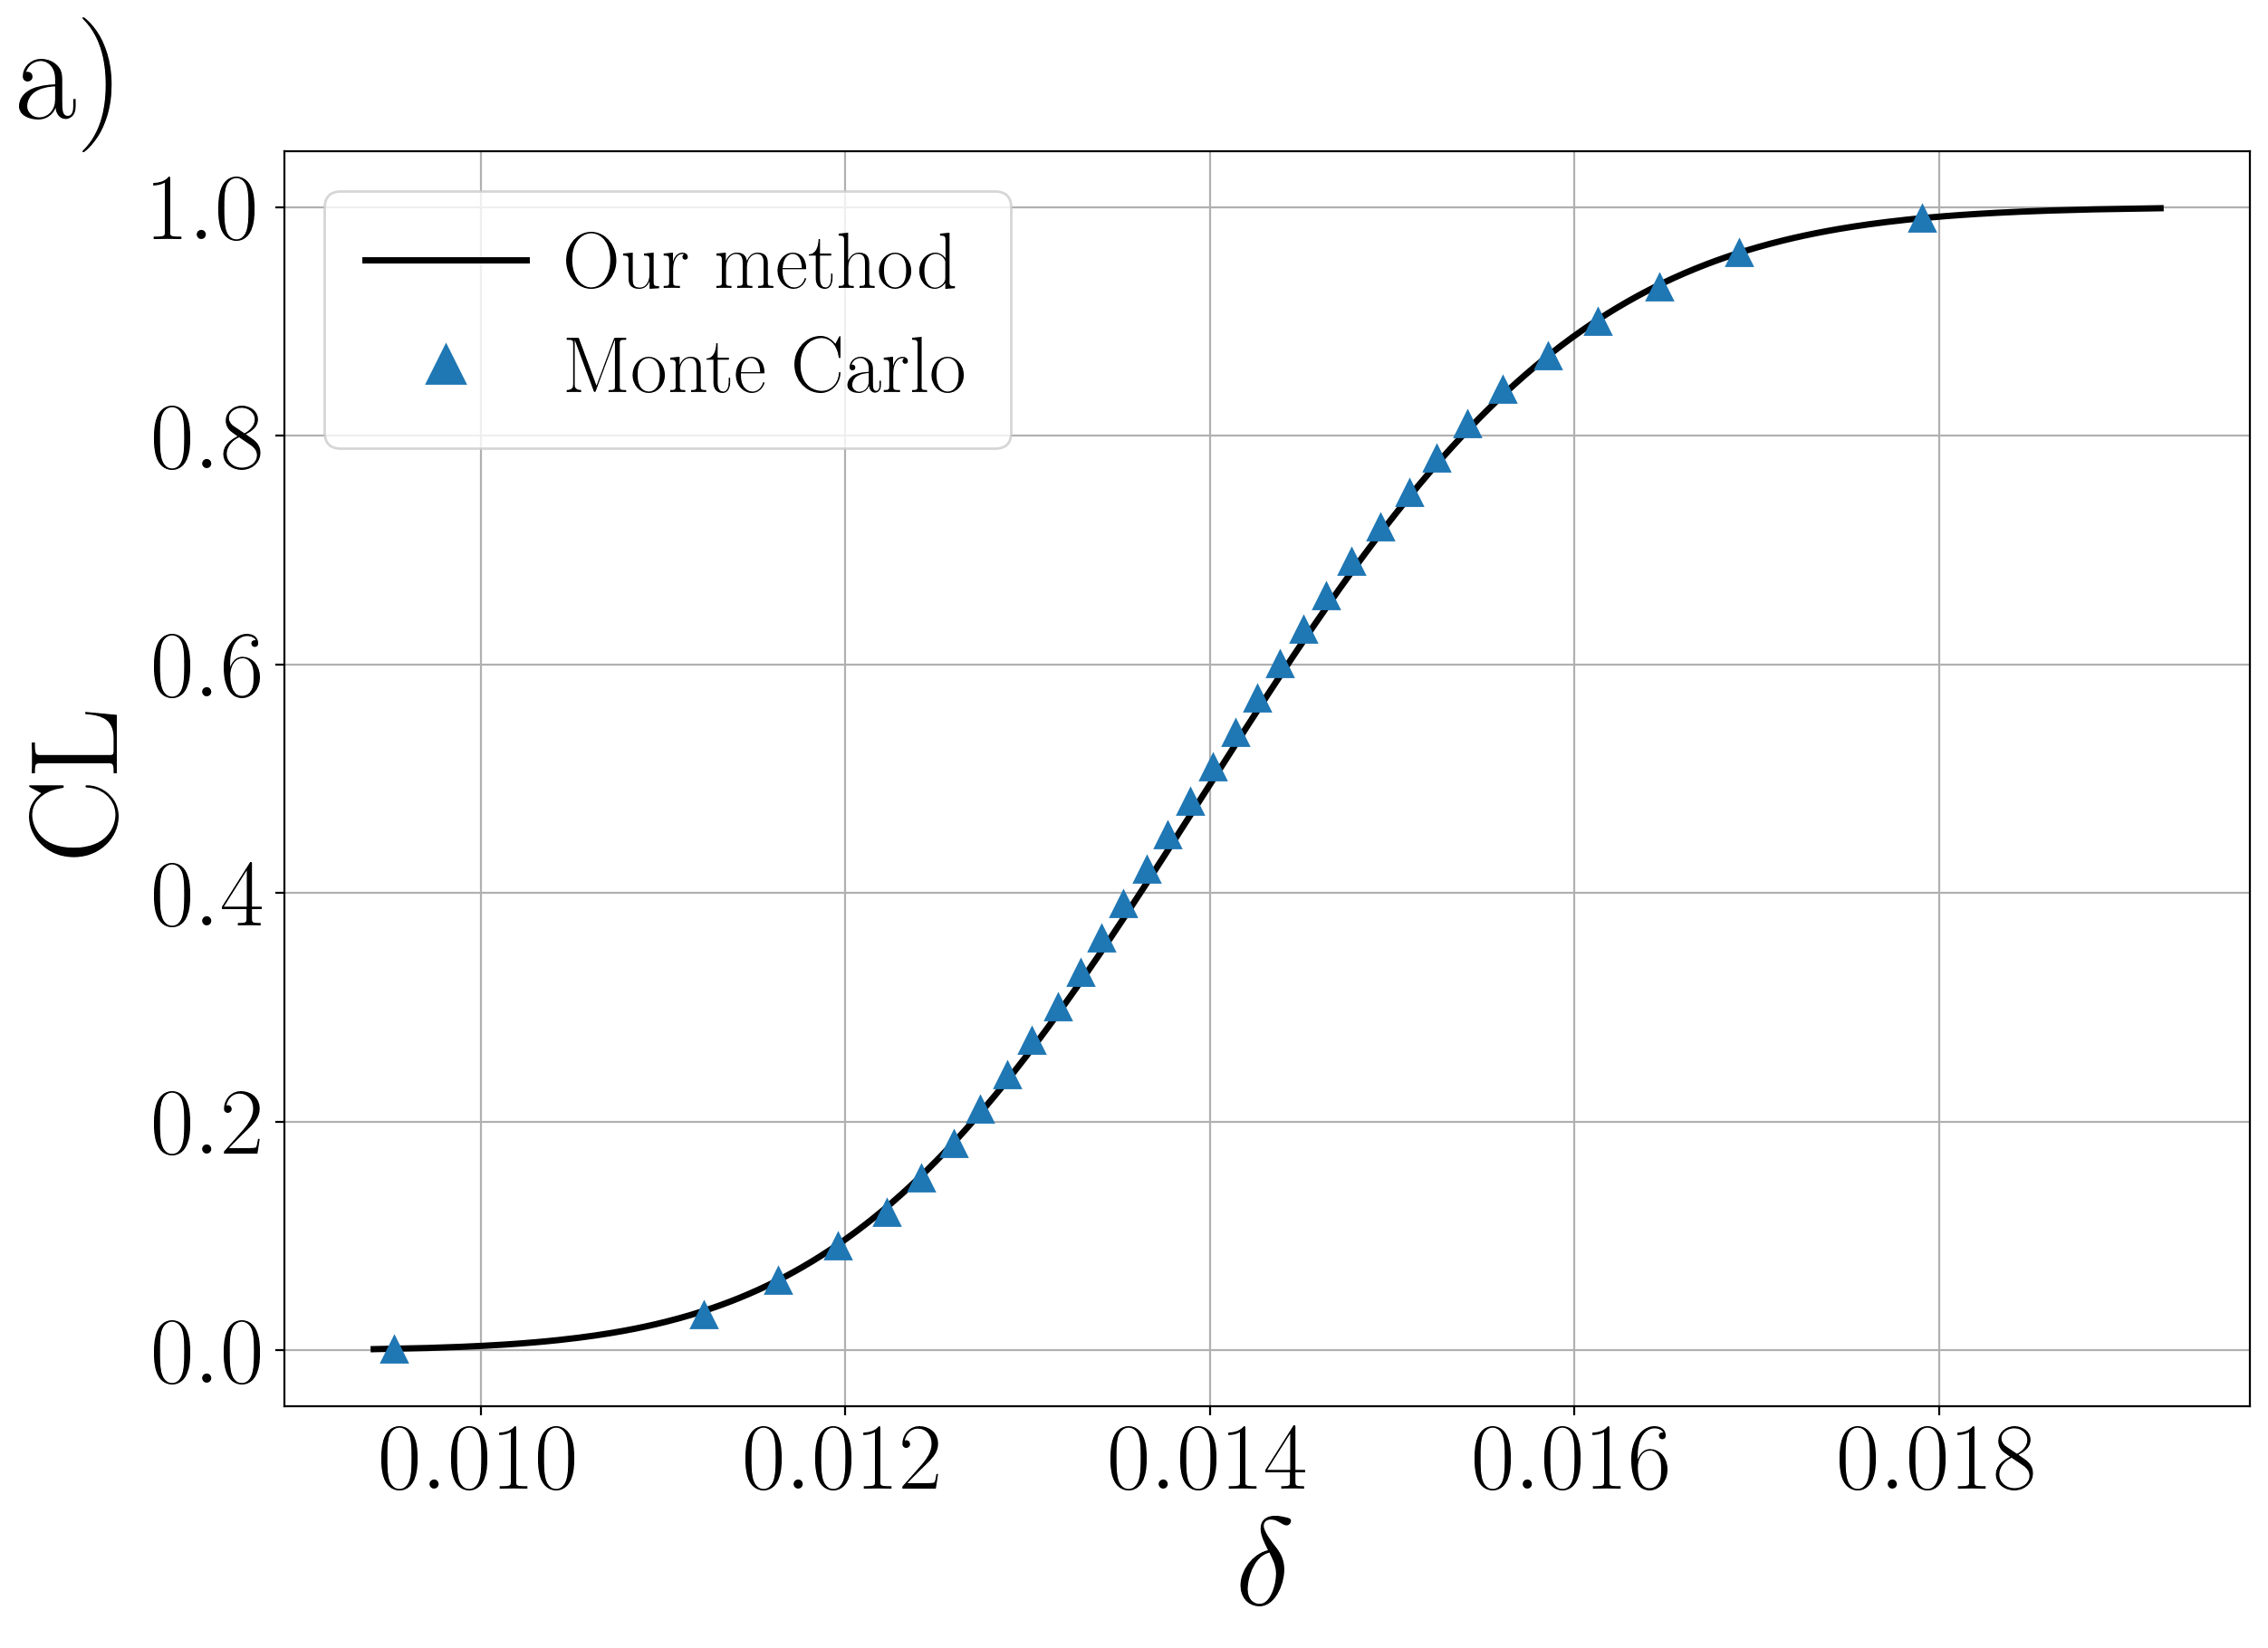

In [7]:
# state = states.iloc[6]
# tmg = qp.StateTomograph(state['state'])
# tmg.experiment(int(state['n_meas']), povm='proj-set')
# intervals = {
# #     'Bootstrap': qp.BootstrapStateInterval(tmg, state=tmg.point_estimate(physical=True), physical=False),
# #     'Japan': qp.SugiyamaInterval(tmg),
#     'Moments': qp.MomentInterval(tmg),
#     'Monte Carlo': qp.BootstrapStateInterval(tmg, n_points=10000, state=state['state'], physical=False),
# }

# results = {}

# for name, interval in intervals.items():
#     results[name] = interval()

# x_max = max([dist[np.asarray(CLs > 0.99).nonzero()[0][0]] for dist, CLs in results.values()]) 
# x_min = min([dist[np.asarray(CLs > 0.01).nonzero()[0][0]] for dist, CLs in results.values()])
# x_min -= (x_max - x_min) * 0.1
# x_max += (x_max - x_min) * 0.1

plt.figure(figsize=(14, 9), dpi=200)
plt.grid()
plt.xlabel('$\\delta$')
plt.ylabel('CL')
plt.plot(results["Moments"][0], results["Moments"][1], "-k", label="Our method")
plt.plot(results["Monte Carlo"][0][::30], results["Monte Carlo"][1][::30], "^", label="Monte Carlo", markersize=10)
plt.legend()
plt.figtext(0.02, 0.9, "a)")
plt.savefig("../data/fig_1a.pdf", bbox_inches='tight')

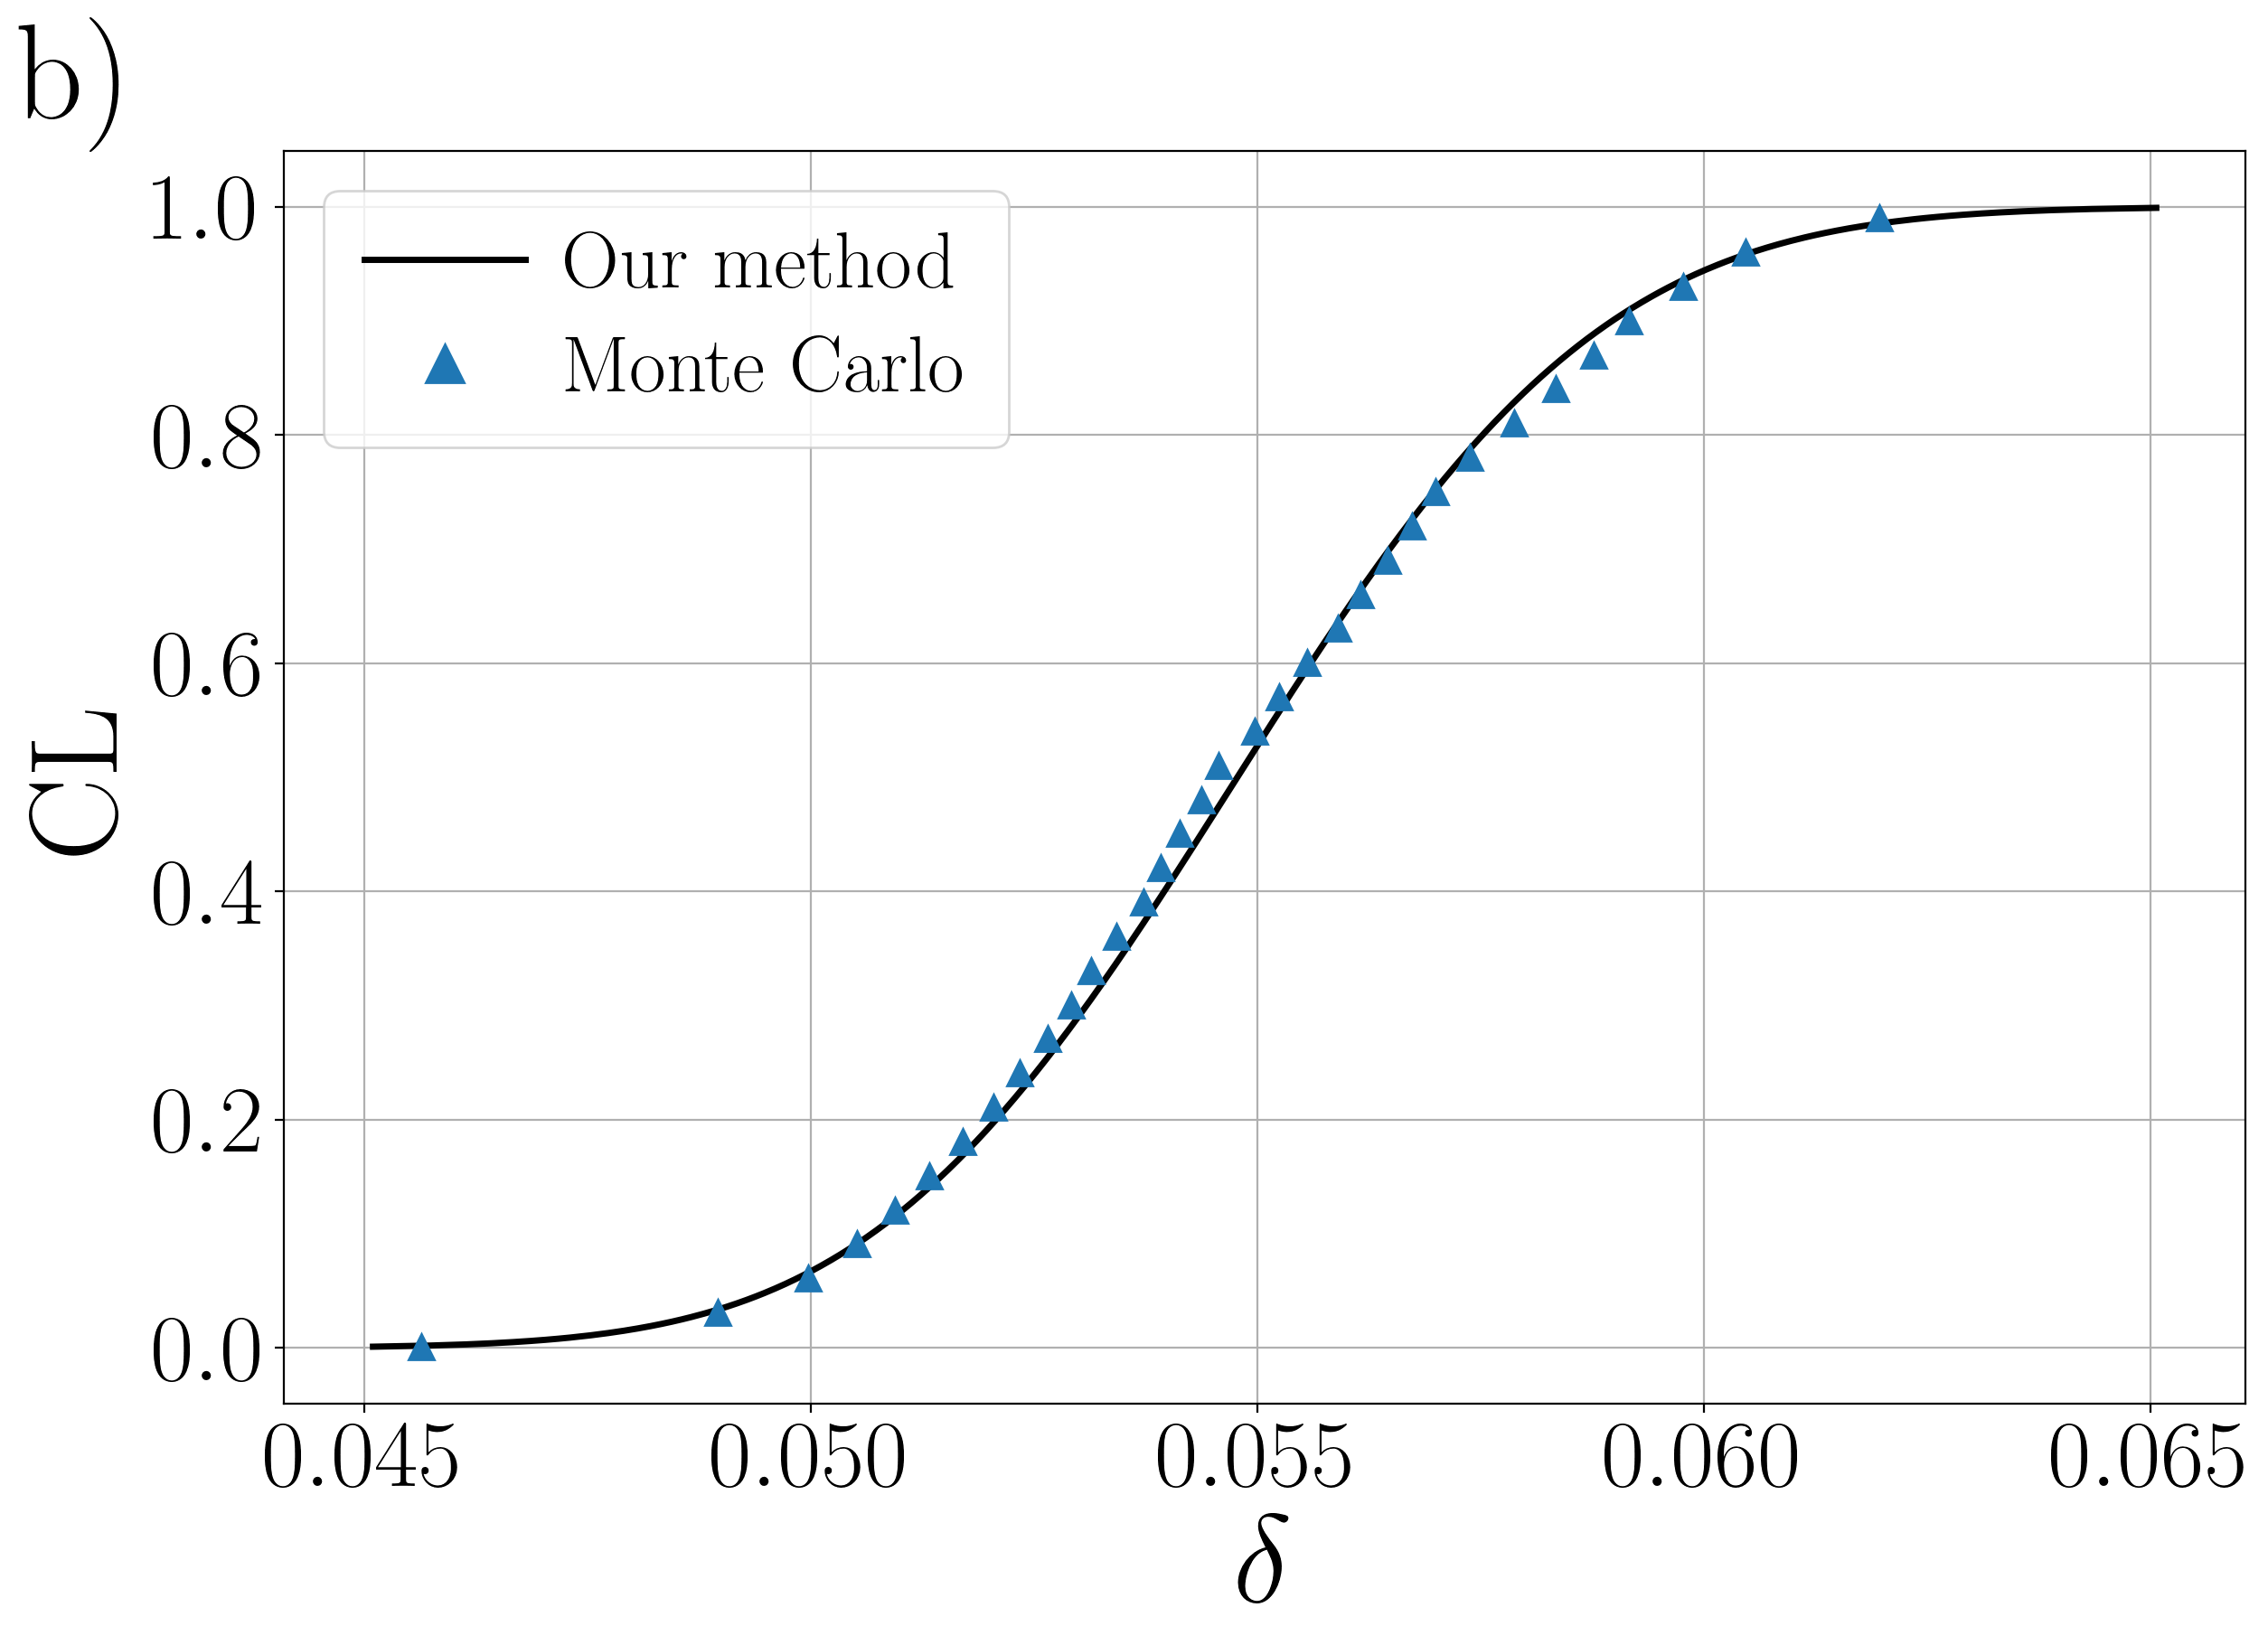

In [11]:
process = processes.iloc[4]
process_name = process['name']
tmg = qp.ProcessTomograph(process['process'], input_states='sic')
tmg.experiment(int(process['n_meas']), povm='proj-set')
intervals = {
    'Moments': qp.MomentInterval(tmg),
    'Monte Carlo': qp.BootstrapProcessInterval(tmg, n_points=1000, channel=process['process'], cptp=False),
}

results = {}

for name, interval in intervals.items():
    results[name] = interval()

x_max = max([dist[np.asarray(CLs > 0.99).nonzero()[0][0]] for dist, CLs in results.values()]) 
x_min = min([dist[np.asarray(CLs > 0.01).nonzero()[0][0]] for dist, CLs in results.values()])
x_min -= (x_max - x_min) * 0.1
x_max += (x_max - x_min) * 0.1

plt.figure(figsize=(14, 9), dpi=200)
plt.grid()
plt.xlabel('$\\delta$')
plt.ylabel('CL')
plt.plot(results["Moments"][0], results["Moments"][1], "-k", label="Our method")
plt.plot(results["Monte Carlo"][0][::30], results["Monte Carlo"][1][::30], "^", label="Monte Carlo", markersize=10)
plt.legend()
plt.figtext(0.02, 0.9, "b)")
plt.savefig("../data/fig_1b_2.pdf", bbox_inches='tight')

### States

In [ ]:
pl

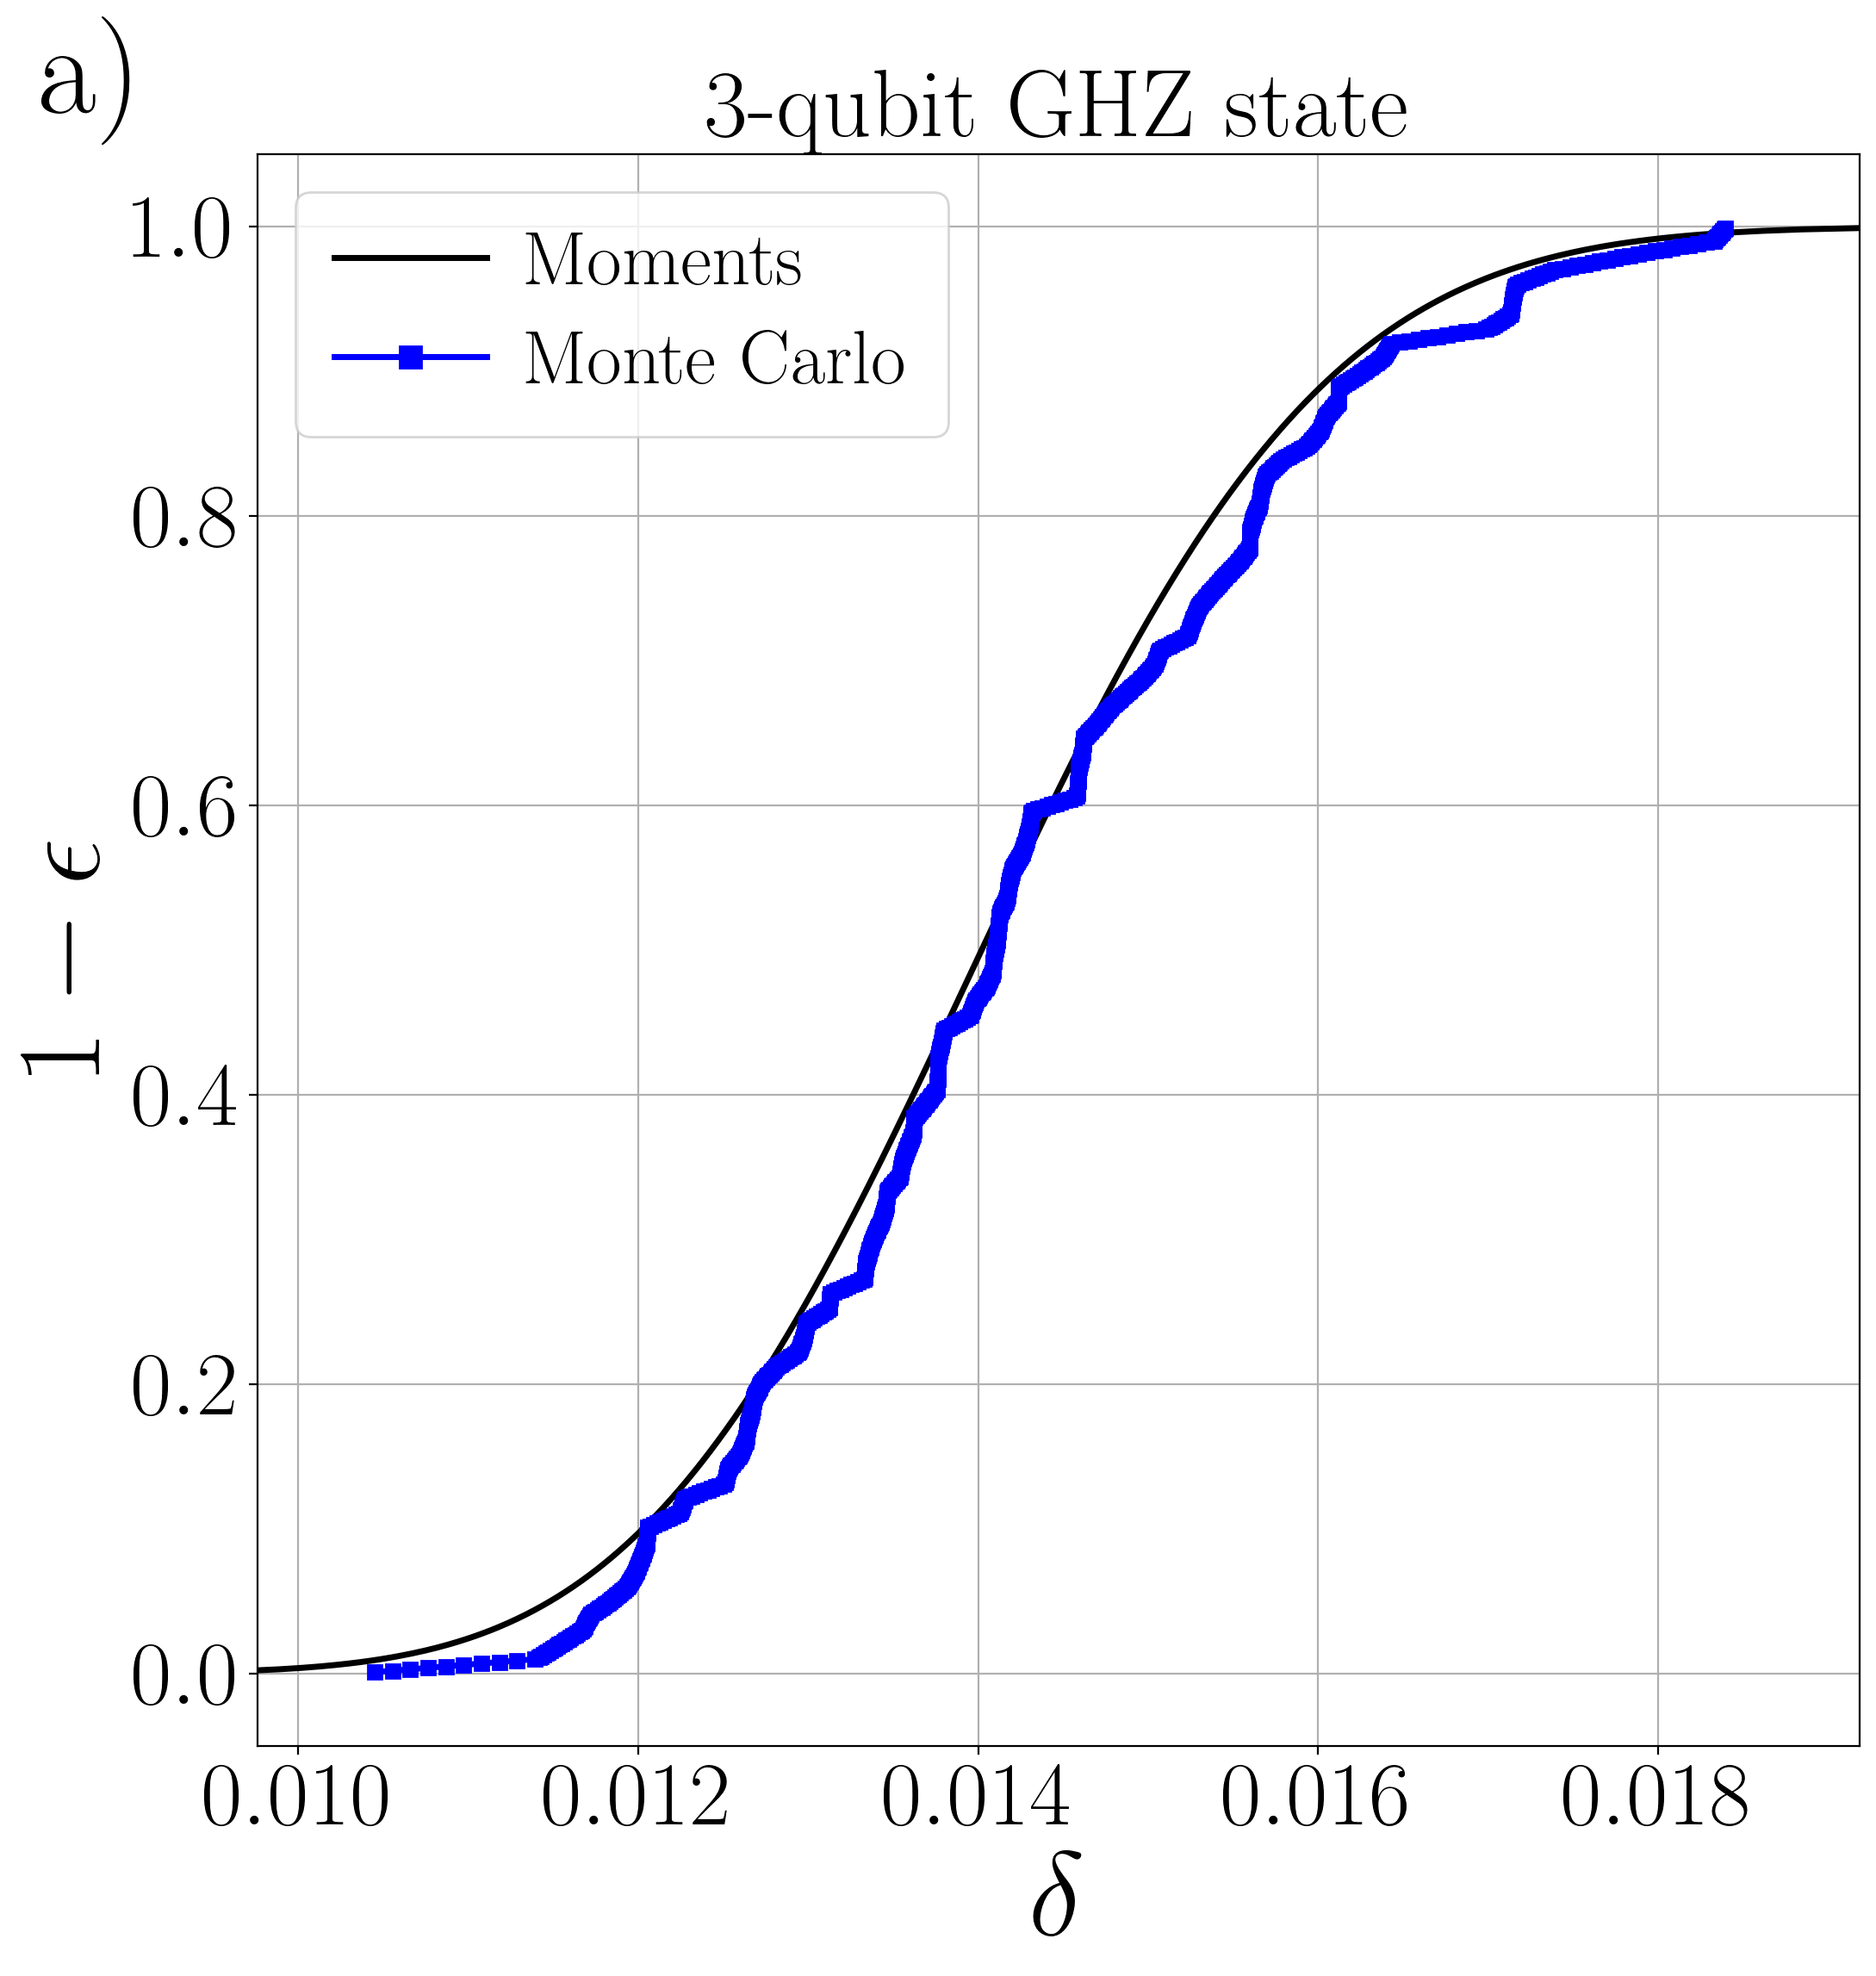

In [55]:
cc = cycler(color=list('kb')) + cycler(marker=['', 's'])
for i in [6]:
    state = states.iloc[i]
#     state['state'] = qp.qobj.GHZ(4)
#     state['name'] = "4-qubit GHZ state"
    tmg = qp.StateTomograph(state['state'])
    tmg.experiment(int(state['n_meas']), povm='proj-set')
    intervals = {
#         'Bootstrap': qp.BootstrapStateInterval(tmg, state=tmg.point_estimate(physical=True), physical=False),
#         'Japan': qp.SugiyamaInterval(tmg),
        'Moments': qp.MomentInterval(tmg),
        'Monte Carlo': qp.BootstrapStateInterval(tmg, n_points=100, state=state['state'], physical=False),
#         'Moments-norm': qp.MomentInterval(tmg, distr_type='norm')
    }
    plot_intervals(intervals, title=state['title'], figtext="a)", figsize=(12, 12), img_path="../data/fig_1a.pdf", cc=cc)

In [ ]:
cc = cycler(color=list('kbgr'))
for i in [-2]:
    state = states.iloc[i]
    state['state'] = qp.qobj.GHZ(4)
    state['name'] = "4-qubit GHZ state"
    state_name = state['name']
    tmg = qp.StateTomograph(state['state'])
    tmg.experiment(int(state['n_meas']), povm='proj')
    intervals = {
        'Monte Carlo': qp.BootstrapStateInterval(tmg, state=state['state'], physical=False),
#         'Japan': qp.SugiyamaInterval(tmg),
        'Moments': qp.MomentInterval(tmg),
#         'Moments-norm': qp.MomentInterval(tmg, distr_type='norm')
    }
    plot_intervals(intervals, title=state['title'])

/home/esthete/.cache/pypoetry/virtualenvs/quantpy-6Nkv8DWY-py3.7/lib/python3.7/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


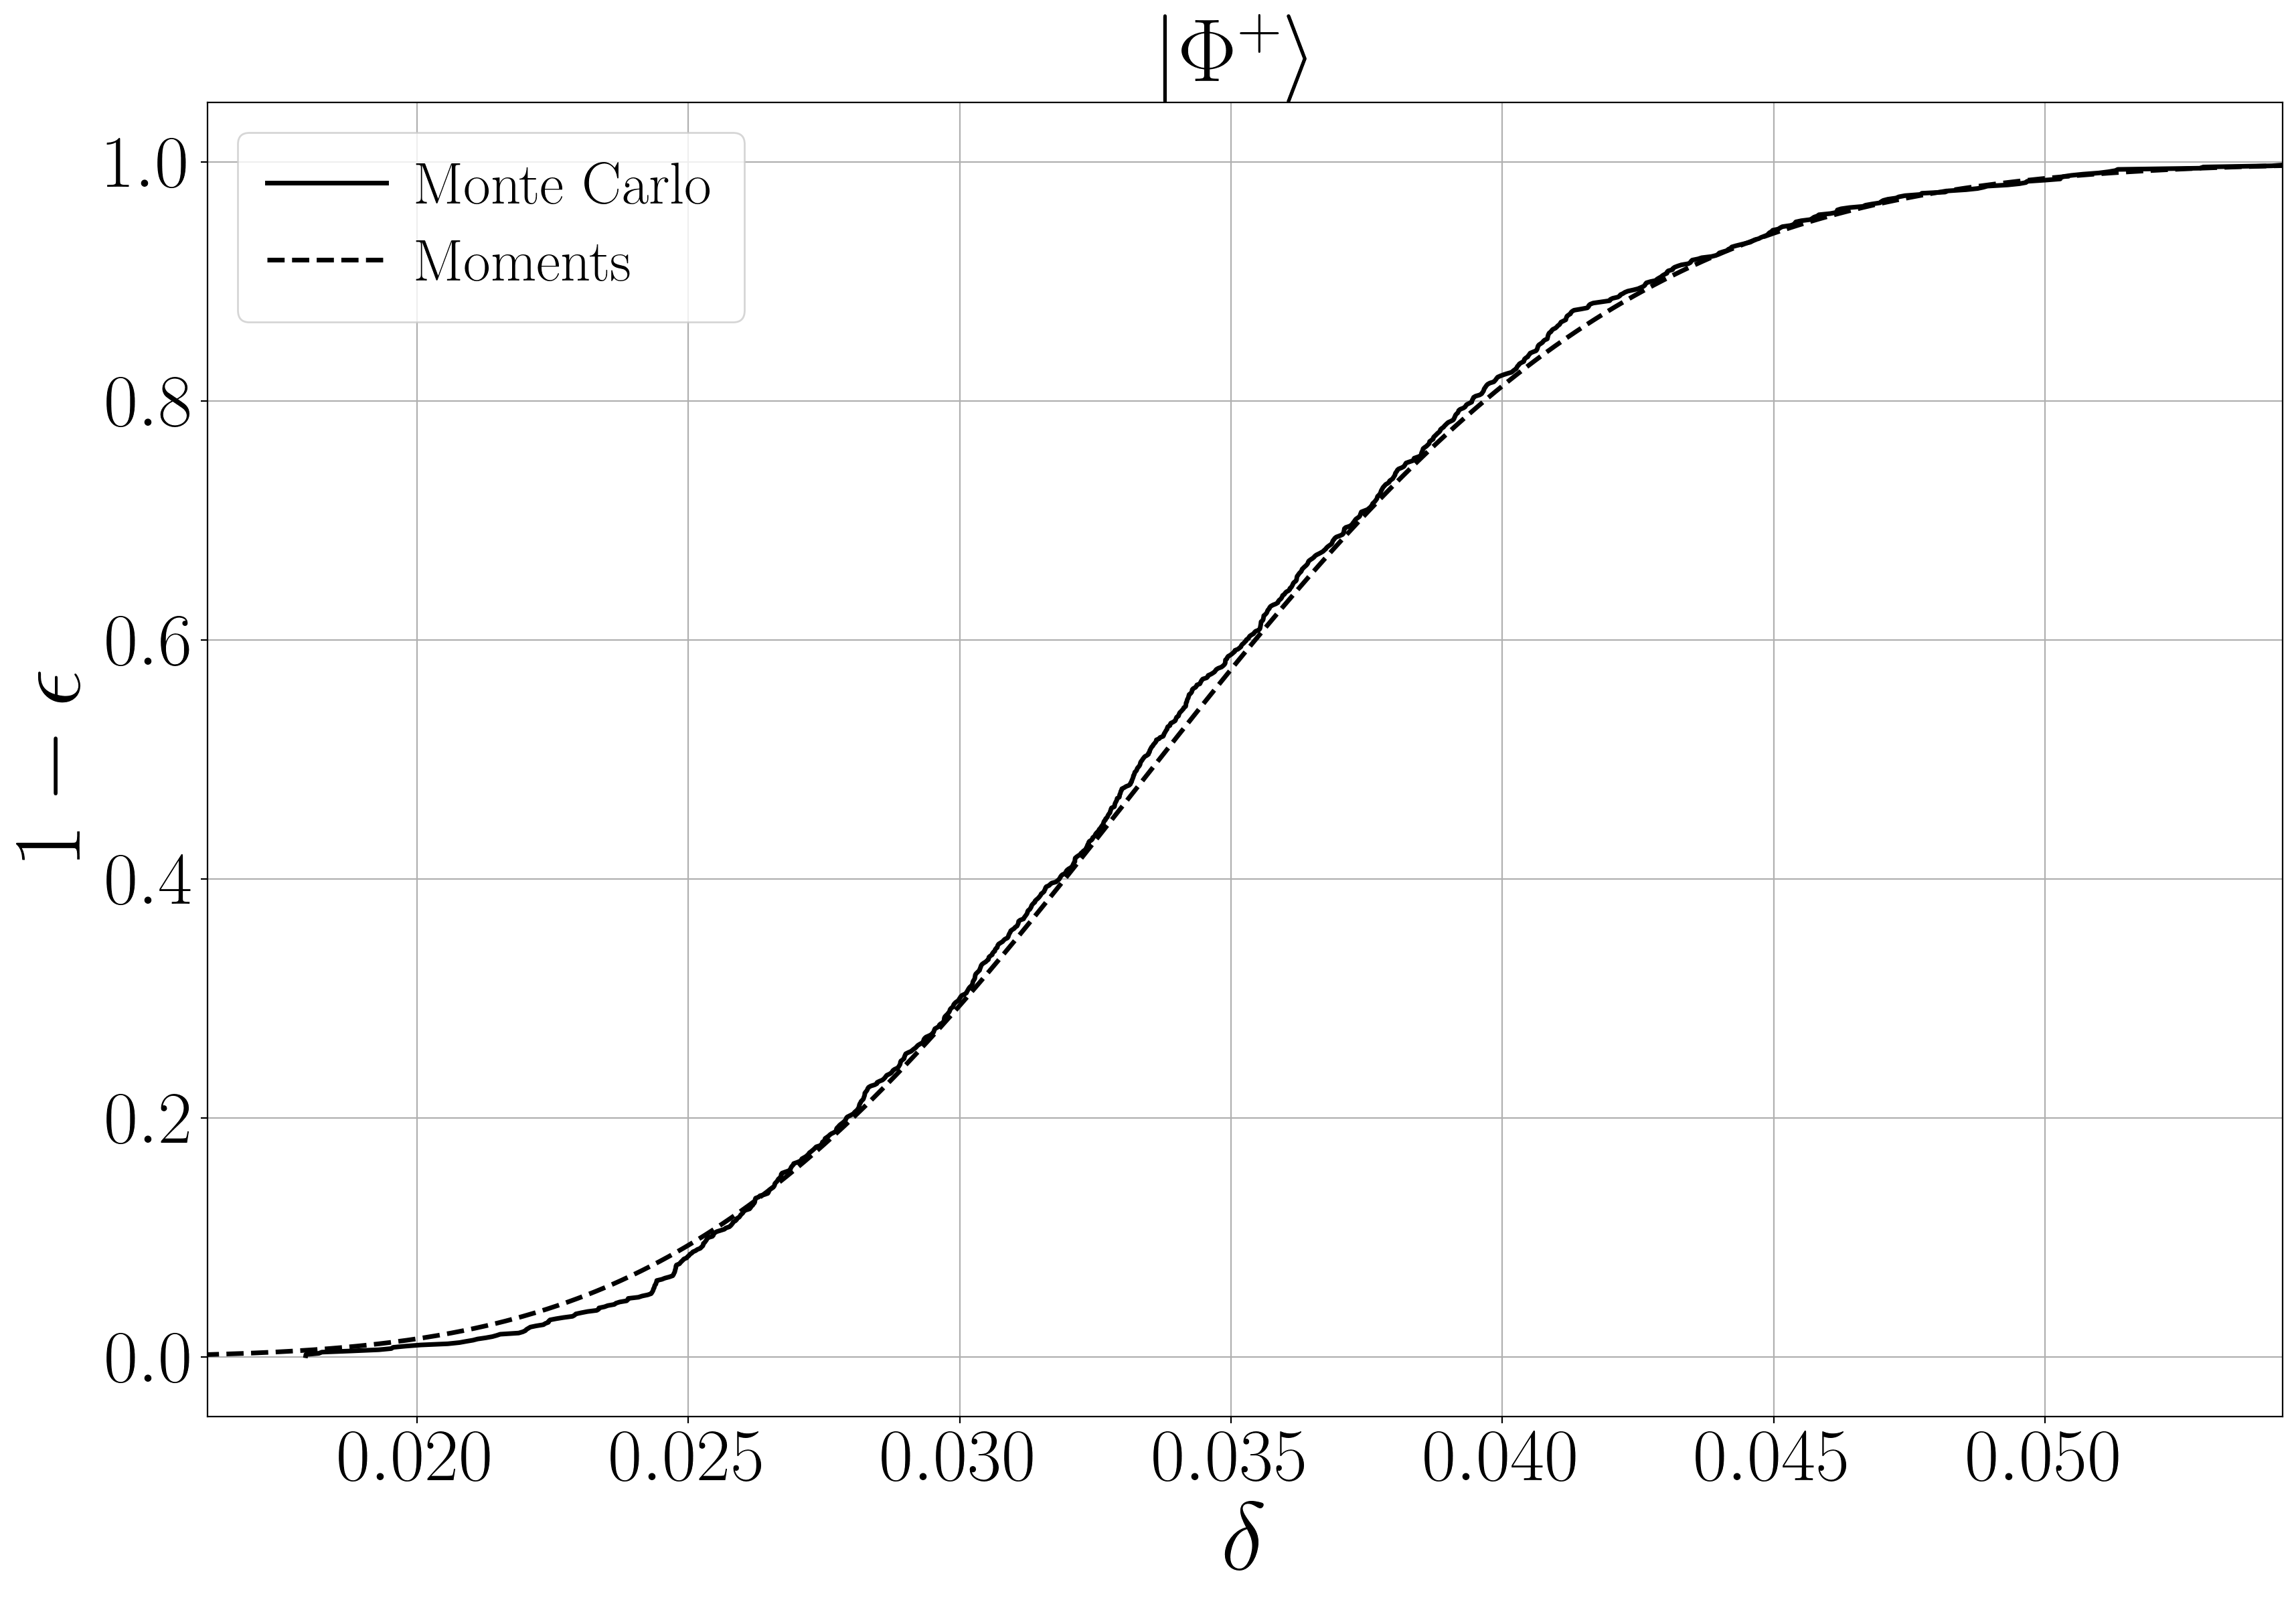

In [10]:
cc = cycler(color=list('kbgr'))
for i in [-2]:
    state = states.iloc[i]
    state['state'] = qp.qobj.GHZ(4)
    state['name'] = "4-qubit GHZ state"
    state_name = state['name']
    tmg = qp.StateTomograph(state['state'])
    tmg.experiment(int(state['n_meas']), povm='proj')
    intervals = {
        'Monte Carlo': qp.BootstrapStateInterval(tmg, state=state['state'], physical=False),
#         'Japan': qp.SugiyamaInterval(tmg),
        'Moments': qp.MomentInterval(tmg),
#         'Moments-norm': qp.MomentInterval(tmg, distr_type='norm')
    }
    plot_intervals(intervals, title=state['title'])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


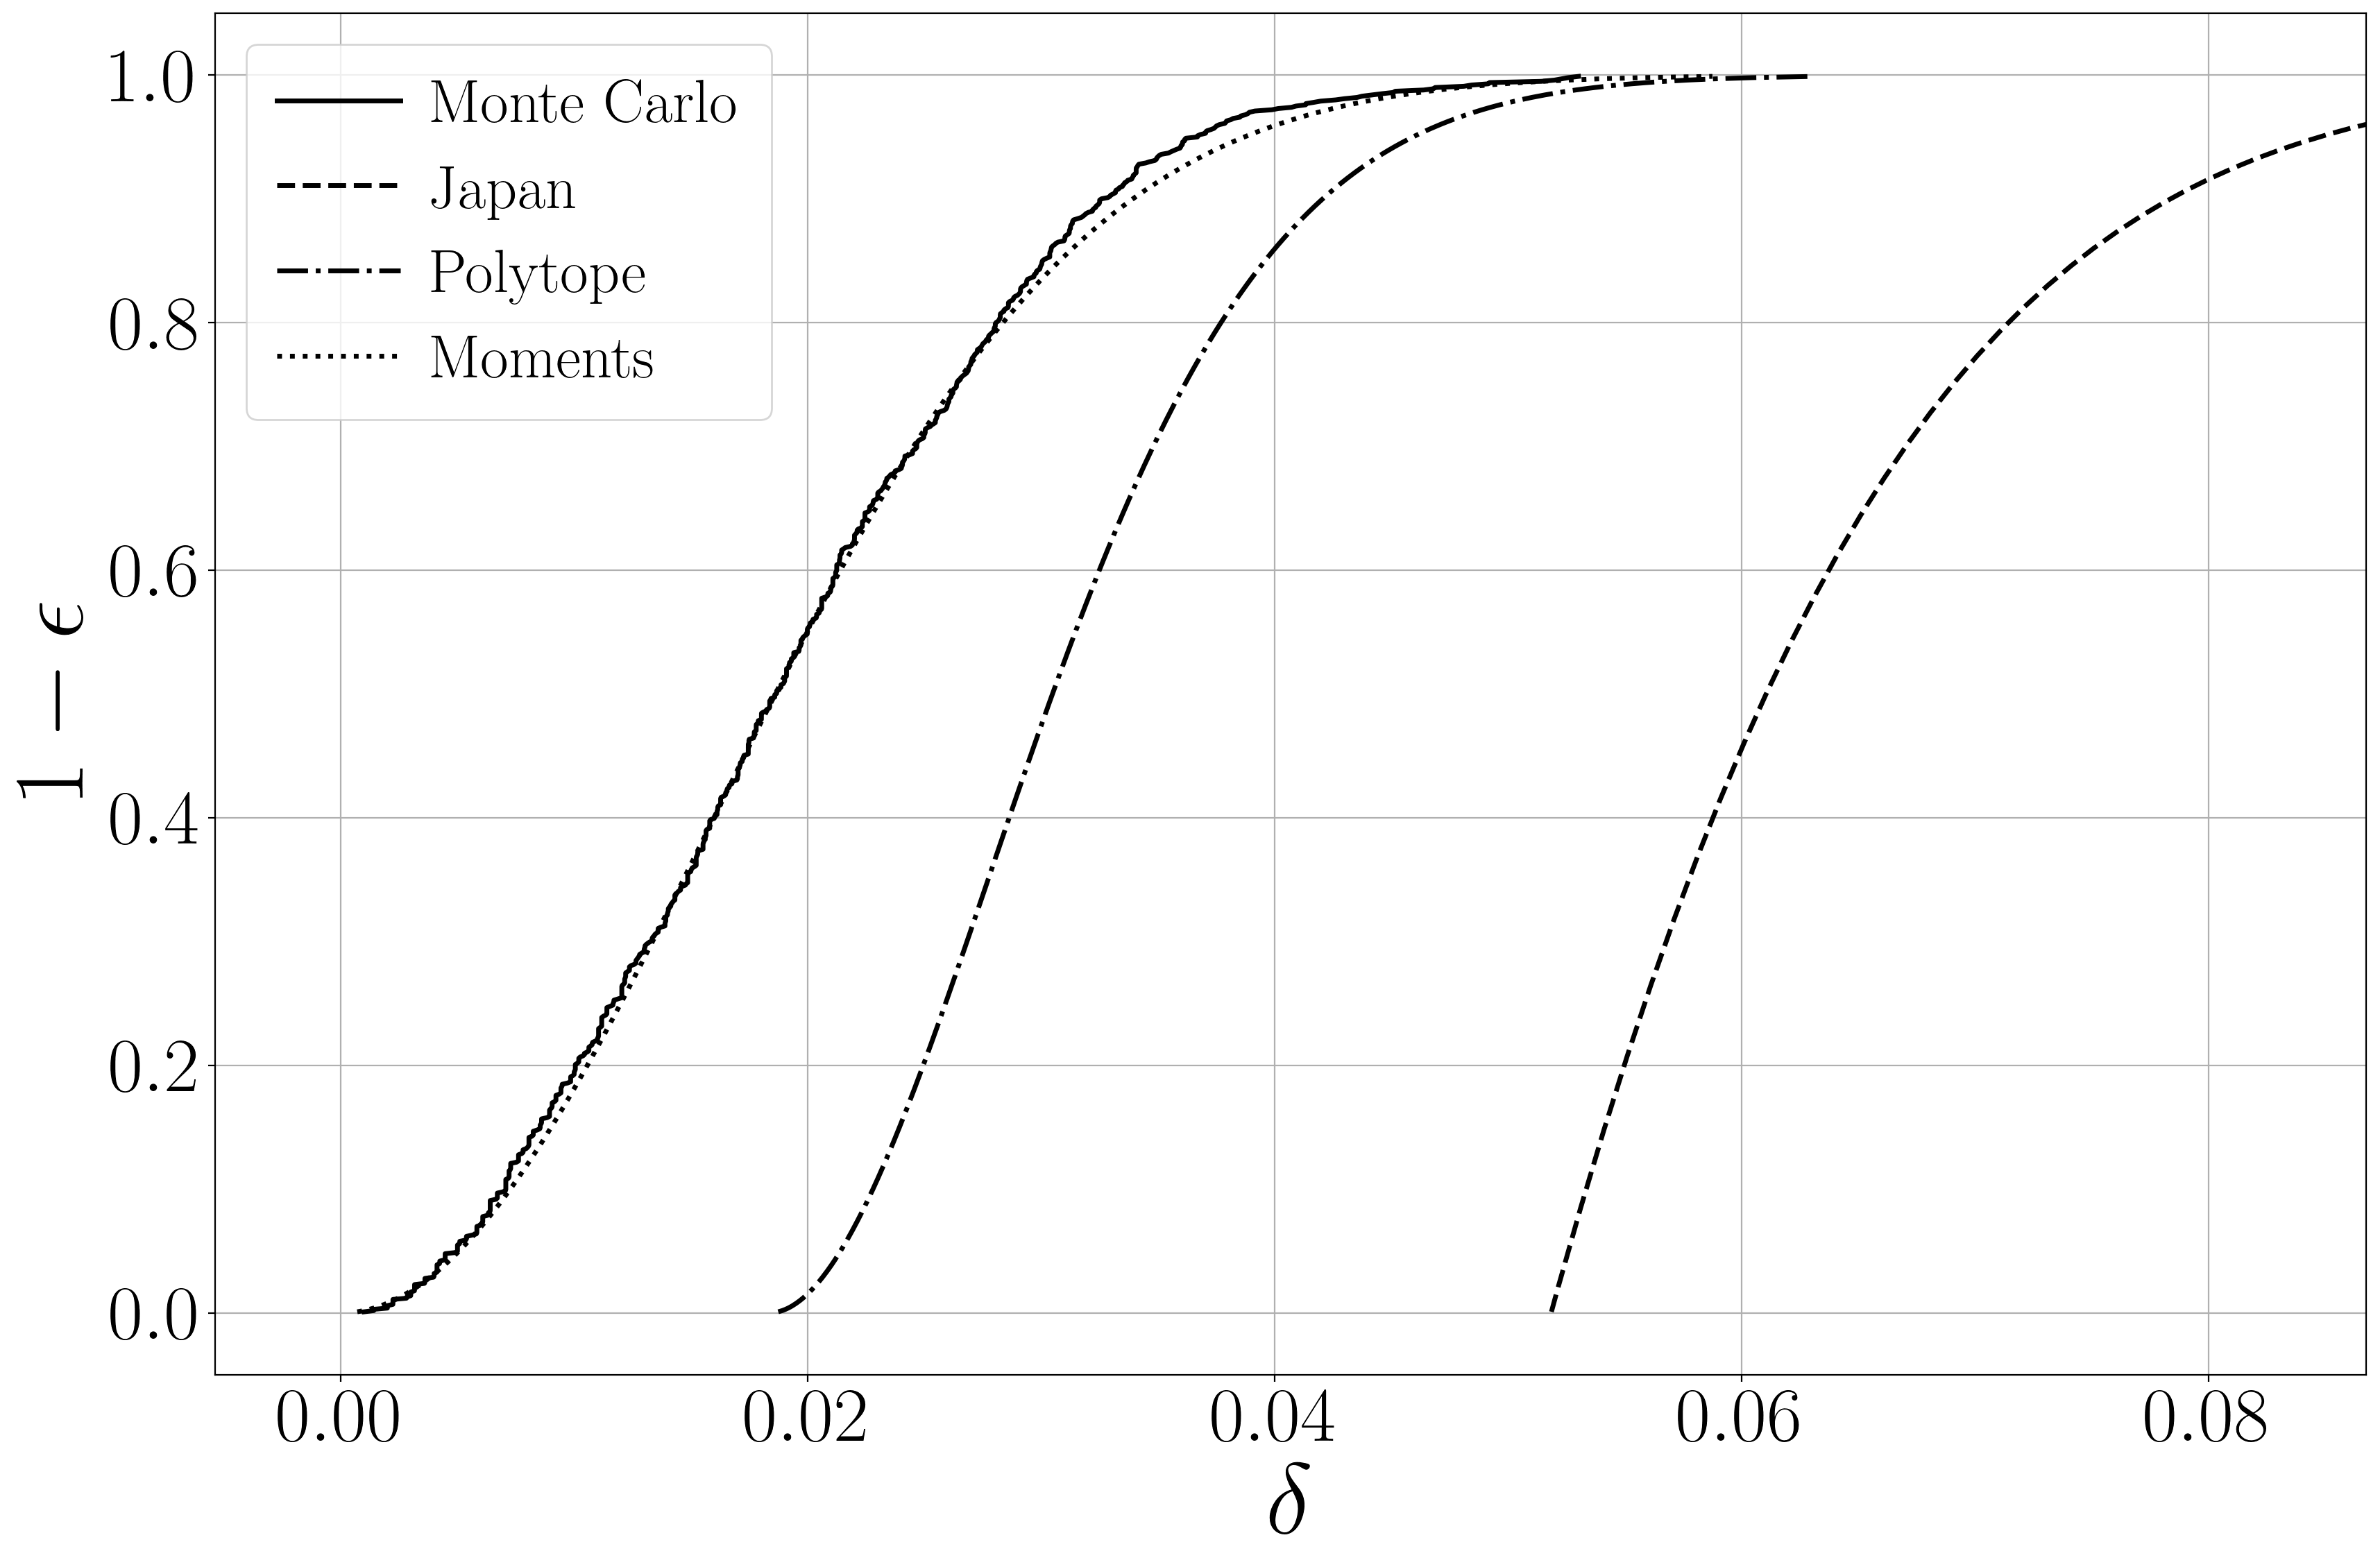

In [7]:
# cc = (cycler(color=list('kbgr')) * cycler(linestyle=['-', '-.', ':', (0, (5, 12))]))
cc = cycler(color=list('kbgr'))
for i in [0]:
    state = states.iloc[i]
    state_name = state['name']
    tmg = qp.StateTomograph(state['state'])
    tmg.experiment(int(state['n_meas']), povm='proj-set')
    intervals = {
        'Monte Carlo': qp.BootstrapStateInterval(tmg, state=state['state']),
        'Japan': qp.SugiyamaInterval(tmg),
        'Polytope': qp.WangInterval(tmg, method='bbox'),
        'Moments': qp.MomentInterval(tmg),
    }
    plot_intervals(intervals)

In [10]:
# cc = (cycler(color=list('kbgr')) * cycler(linestyle=['-', '-.', ':', (0, (5, 12))]))
cc = cycler(color=list('kbgr'))
for i in [0]:
    state = states.iloc[i]
    state_name = state['name']
    tmg = qp.StateTomograph(state['state'])
    tmg.experiment(int(state['n_meas']), povm='proj-set')
    intervals = {
        'Monte Carlo': qp.BootstrapStateInterval(tmg, state=state['state']),
        'Ref. [2]': qp.SugiyamaInterval(tmg),
        'Polytope': qp.WangInterval(tmg, method='bbox'),
        'Moments': qp.MomentInterval(tmg),
    }
    construct_intervals(intervals, f'../imgs/poster/{state_name}.pkl')

/home/esthete/Dropbox/RQC/quantpy/quantpy/tomography/interval.py:112: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt(distr.ppf(CLs)) * alpha * np.linalg.norm(A, ord=2)


In [9]:
# cc = (cycler(color=list('kbgr')) * cycler(linestyle=['-', '-.', ':', (0, (5, 12))]))
cc = cycler(color=list('kbgr'))
for i in [0, 1, 2, 4]:
    state = states.iloc[i]
    state_name = state['name']
    tmg = qp.StateTomograph(state['state'])
    tmg.experiment(int(state['n_meas']), povm='proj-set')
    intervals = {
        'Monte Carlo': qp.BootstrapStateInterval(tmg, state=state['state']),
        'Gamma': qp.MomentInterval(tmg, distr_type='gamma'),
        'Normal': qp.MomentInterval(tmg, distr_type='norm'),
    }
    construct_intervals(intervals, f'../imgs/poster/{state_name}_mom.pkl')

[autoreload of quantpy.tomography.interval failed: Traceback (most recent call last):
  File "/home/esthete/anaconda3/envs/quantpy/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RecursionError: maximum recursion depth exceeded while calling a Python object
]


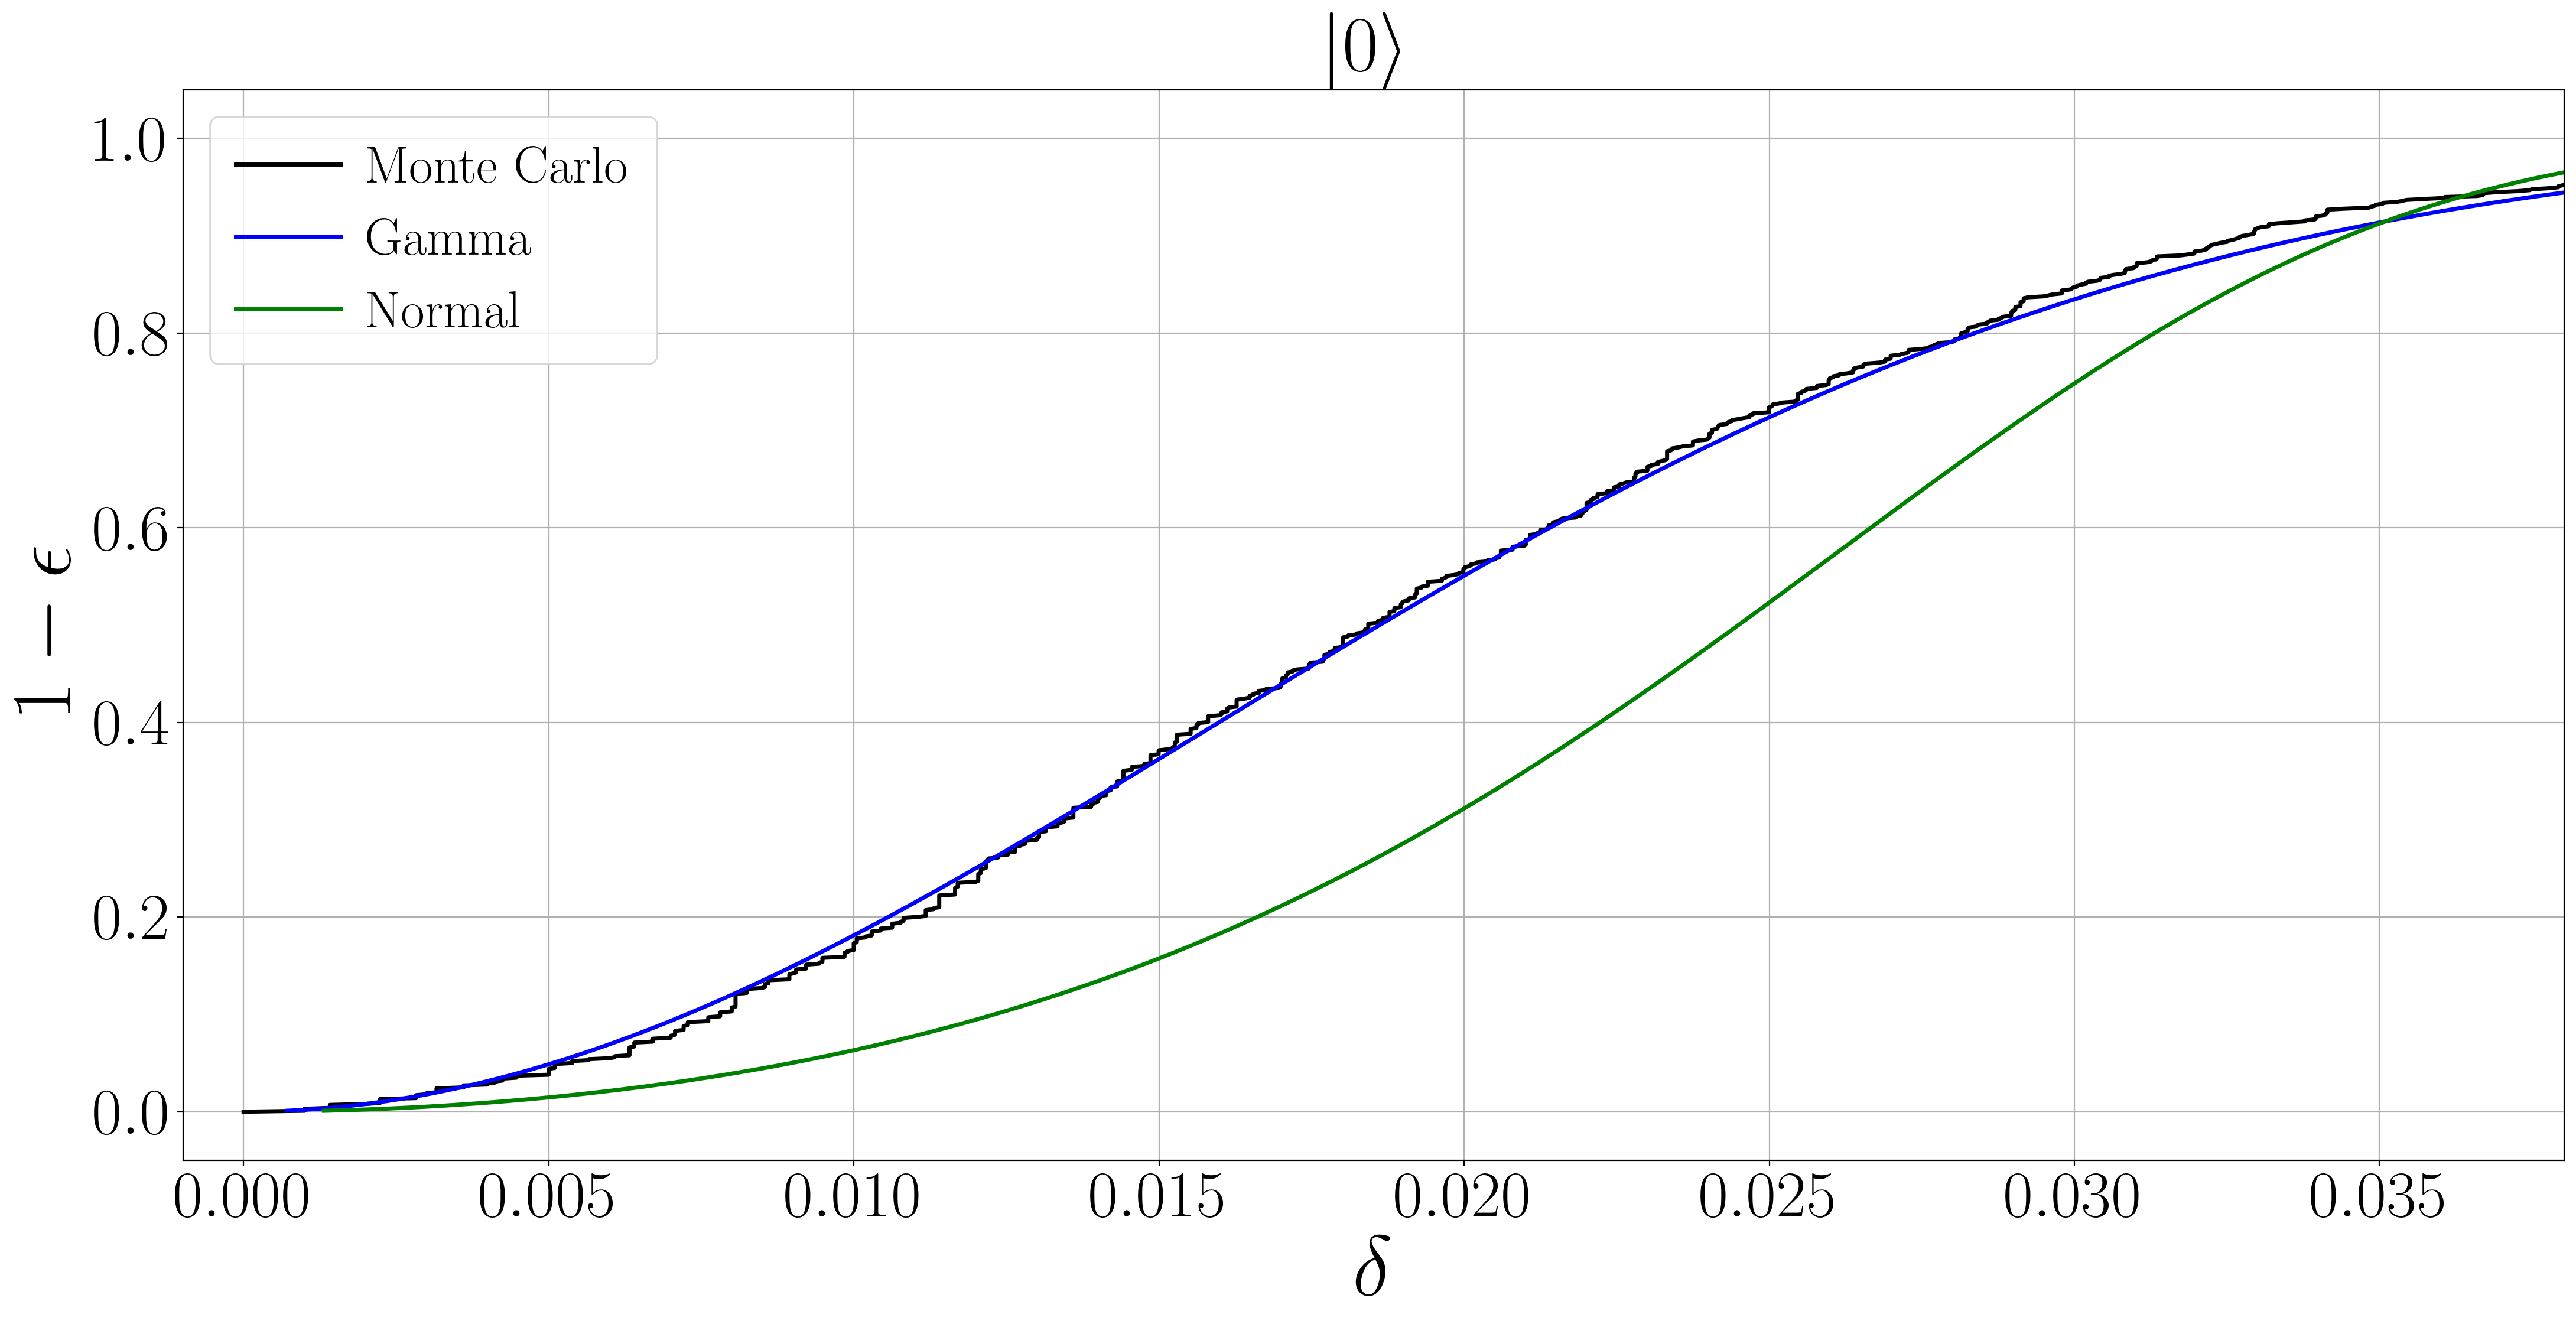

In [10]:
cc = cycler(color=list('kbgr'))
for i in [0]:
    state = states.iloc[i]
    state_name = state['name']
    results = plot_intervals(show=True,
                             results_path=f'../imgs/poster/{state_name}_mom.pkl',
                             title=state['title'], legend=True, cc=cc, figsize=(26, 12))

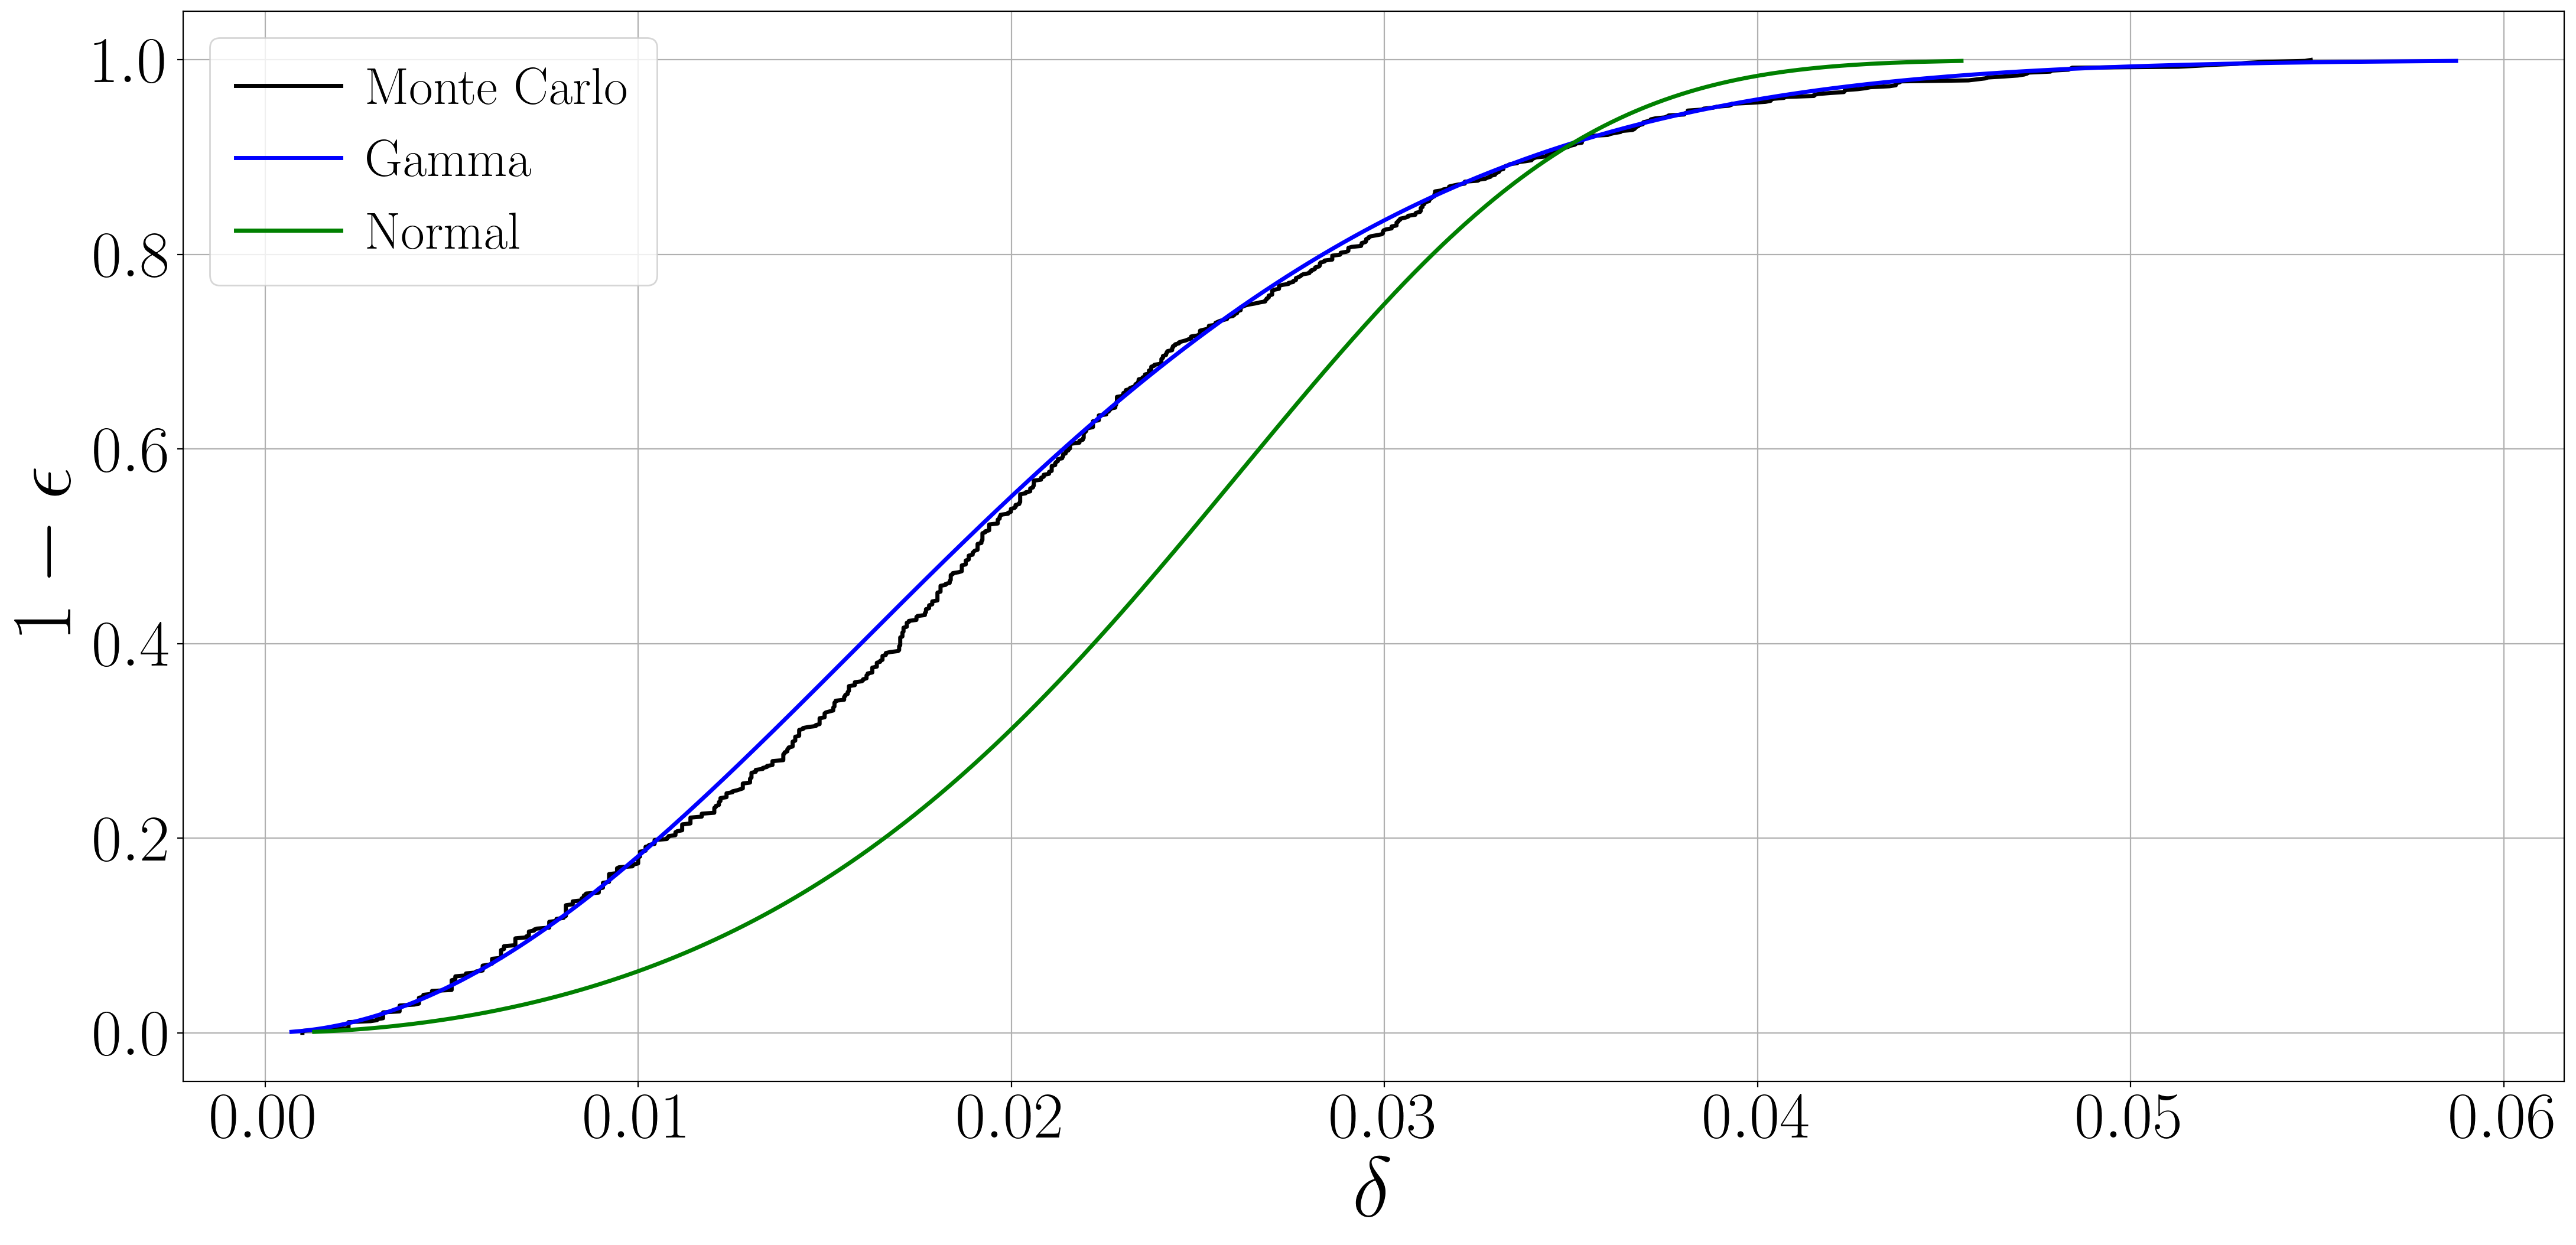

In [11]:
plt.figure(figsize=(26, 12), dpi=200)
    
ax = plt.subplot(111)
ax.grid()
ax.set_xlabel('$\\delta$')
ax.set_ylabel('$1 - \\epsilon$')
ax.set_prop_cycle(cc)

for name, (dist, CLs) in results.items():
    ax.plot(dist, CLs, label=name)
    
ax.legend()
plt.show()

### Processes

In [45]:
processes

,name,process,title,n_meas
0,hadamard,Quantum channel with Choi matrix\narray([[ 0.5...,Hadamard gate,10000
1,rxpi2,Quantum channel with Choi matrix\narray([[0.5+...,$RX(\pi/2)$,10000
2,rypi2,Quantum channel with Choi matrix\narray([[ 0.5...,$RY(\pi/2)$,10000
3,dep1,Quantum channel with Choi matrix\narray([[0.95...,"Depolarizing 1-qubit, p=0.1",10000
4,dep2,Quantum channel with Choi matrix\narray([[0.92...,"Depolarizing 2-qubit, p=0.1",10000
5,cnot,Quantum channel with Choi matrix\narray([[1.+0...,$CNOT$,10000
6,ms,Quantum channel with Choi matrix\narray([[ 0.5...,Mølmer–Sørensen gate,10000


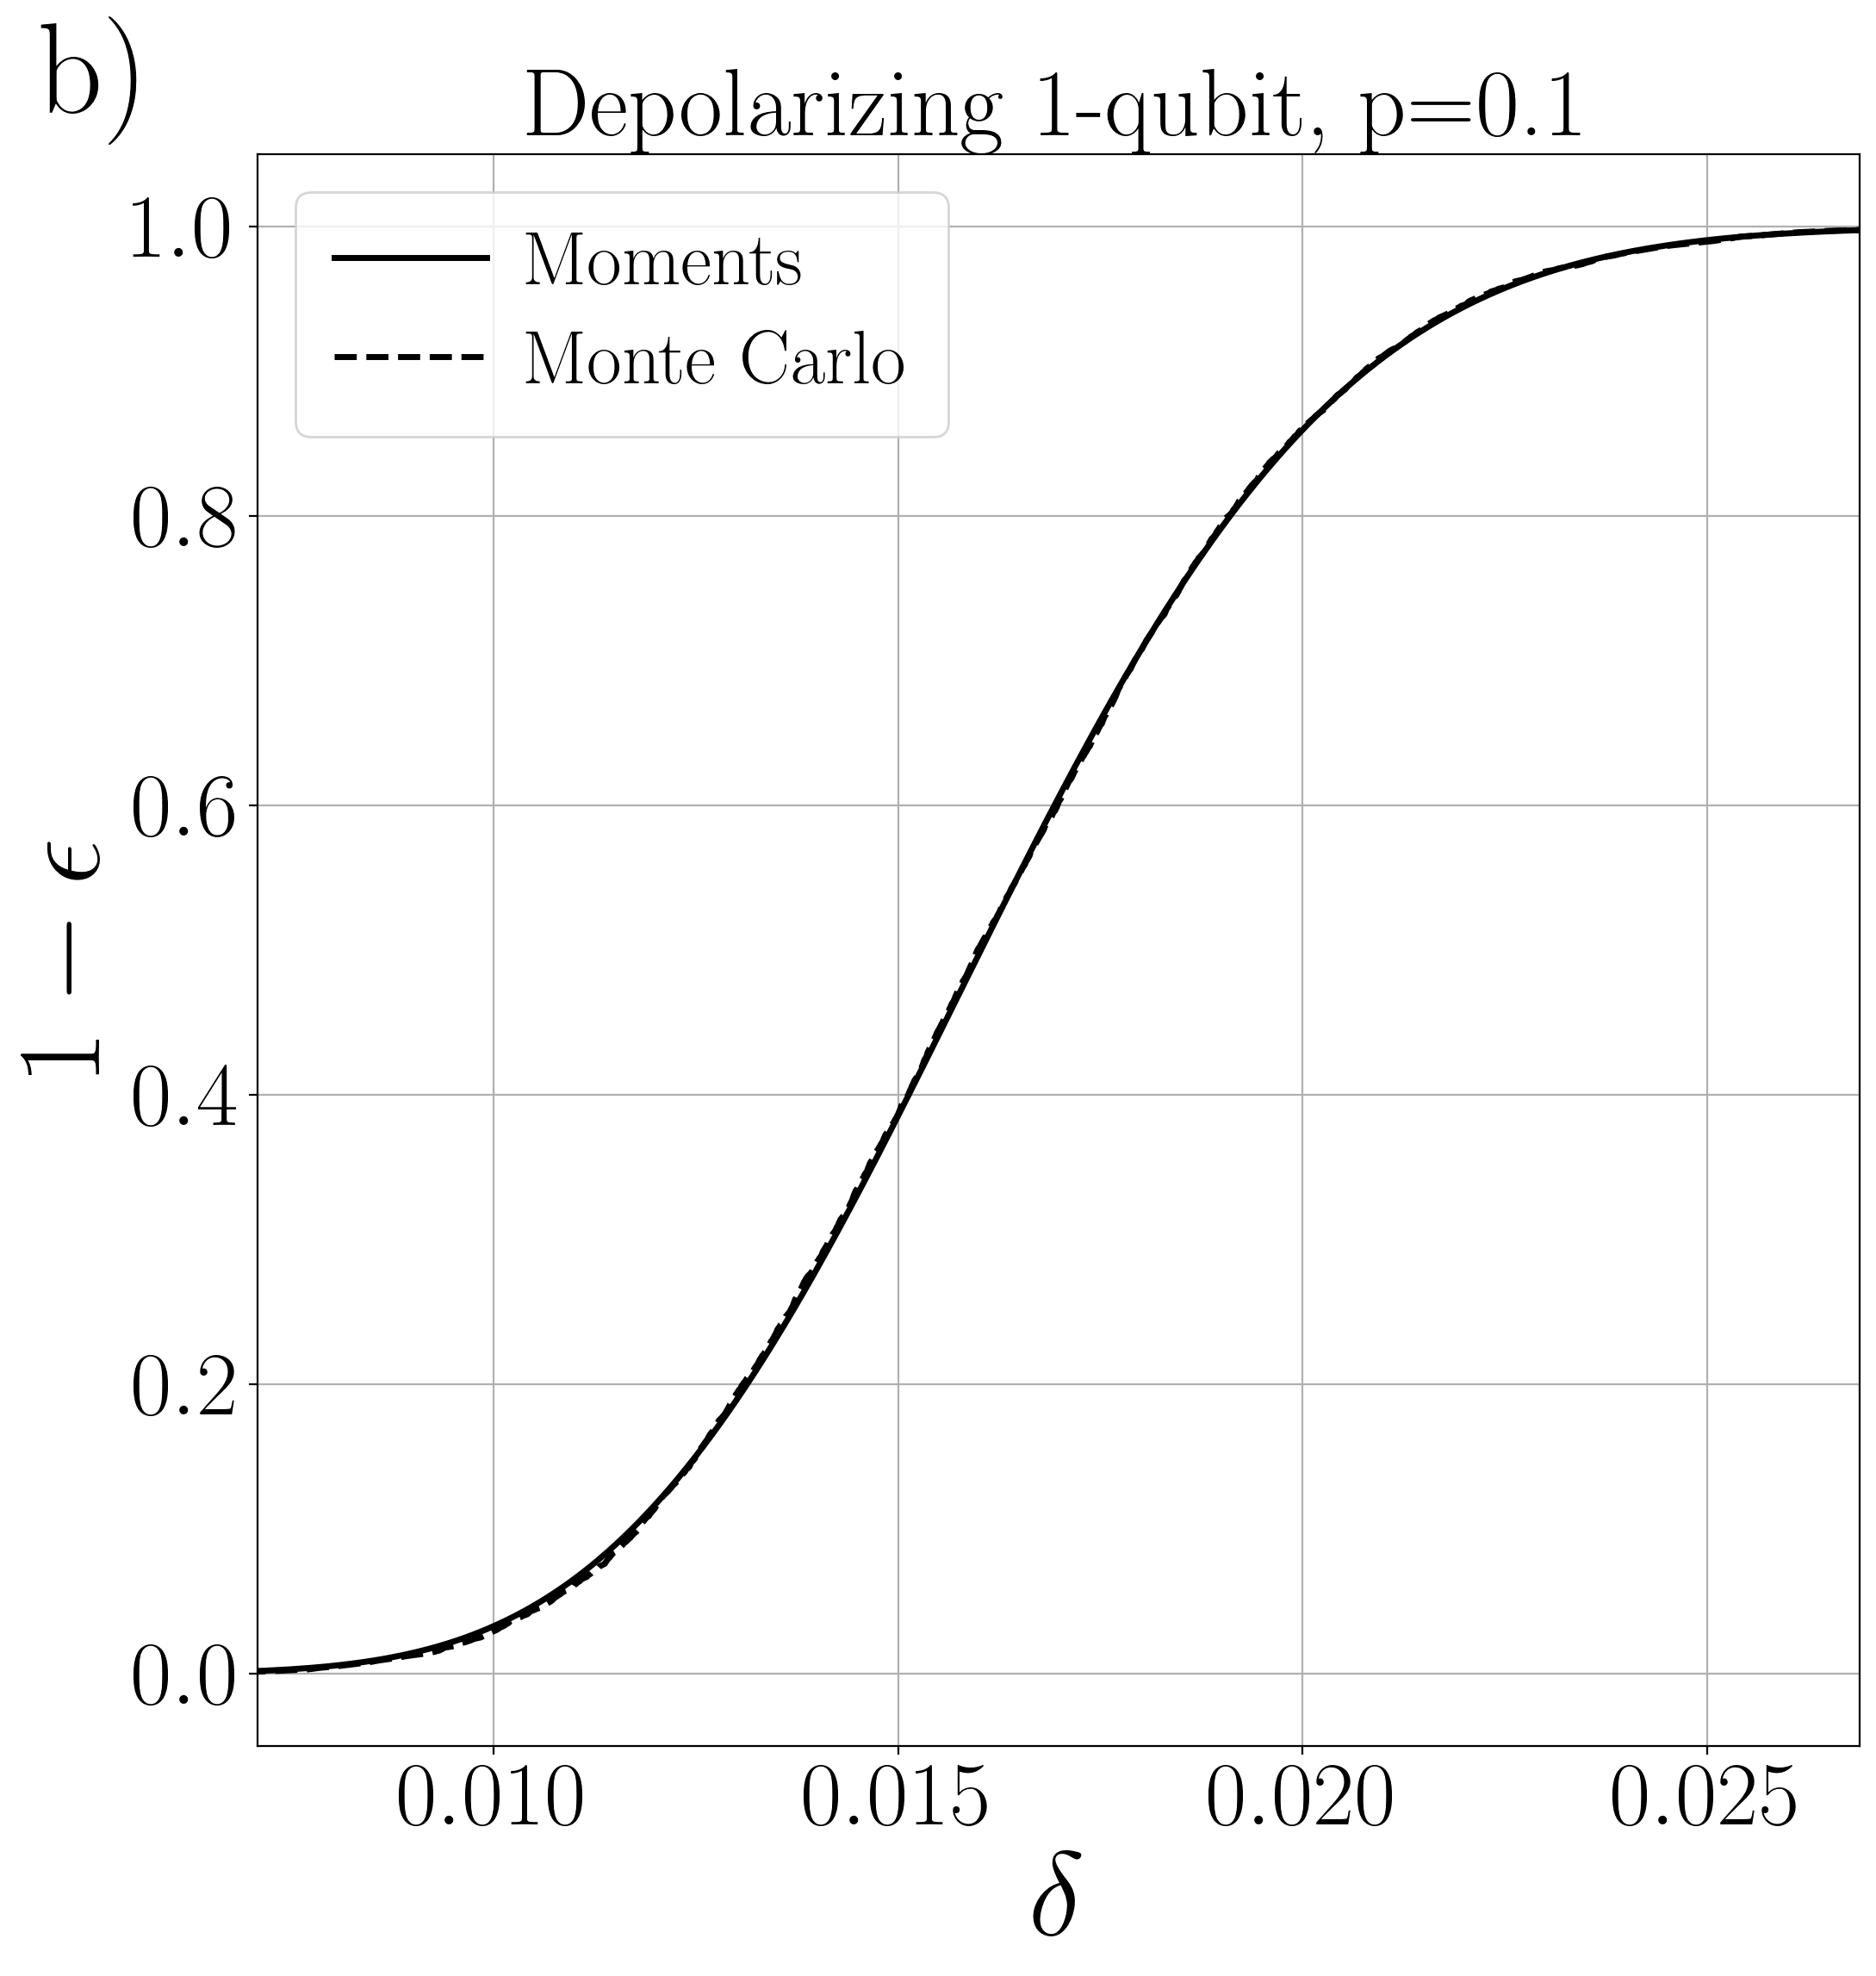

In [48]:
cc = cycler(color=list('kbgry'))
process = processes.iloc[3]
process_name = process['name']
tmg = qp.ProcessTomograph(process['process'], input_states='sic')
tmg.experiment(int(process['n_meas']), povm='proj-set')
intervals = {
    'Moments': qp.MomentInterval(tmg),
    'Monte Carlo': qp.BootstrapProcessInterval(tmg, n_points=10000, channel=process['process'], cptp=False),
}
_ = plot_intervals(intervals, title=process['title'], figtext="b)", figsize=(12, 12), img_path="../data/fig_1b.pdf")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


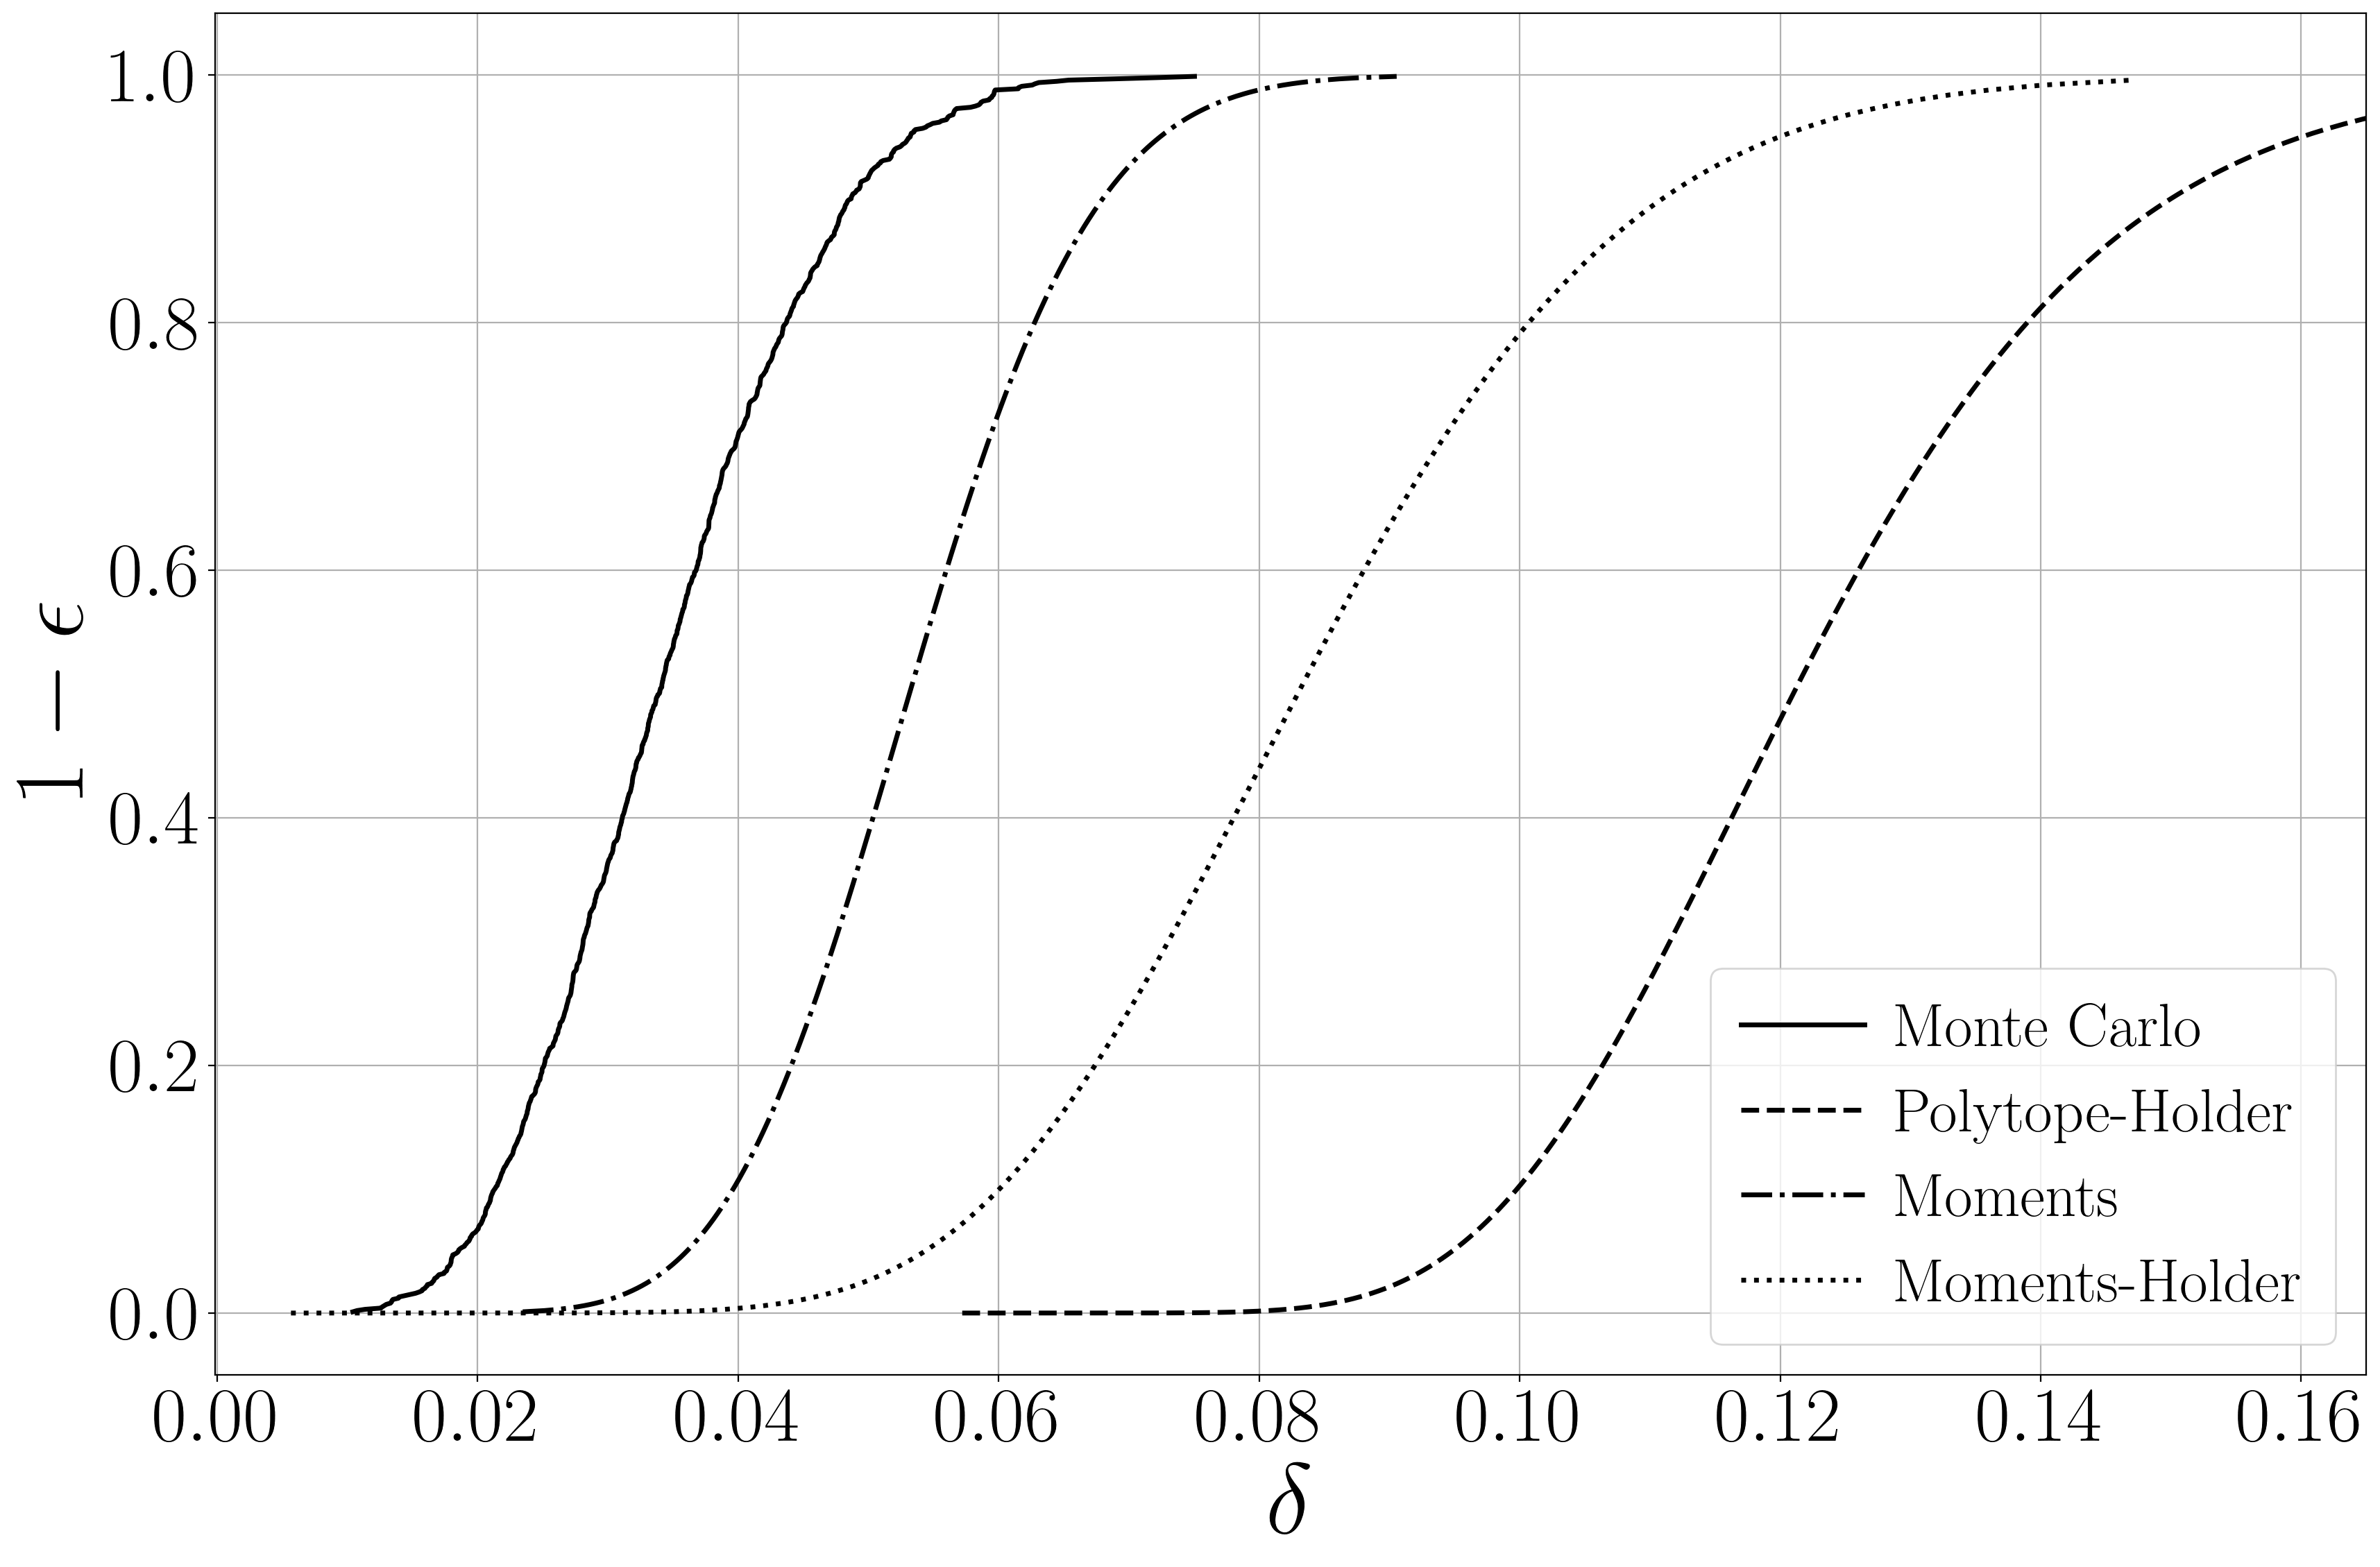

{'Monte Carlo': (array([0.01042, 0.01074, 0.01135, 0.01257, 0.01267, 0.01283, 0.01298,
         0.0133 , 0.01339, 0.01341, 0.01349, 0.01391, 0.01395, 0.01438,
         0.01479, 0.01523, 0.01551, 0.01572, 0.01576, 0.01595, 0.01601,
         0.01612, 0.01614, 0.01646, 0.01651, 0.01662, 0.01665, 0.0167 ,
         0.01686, 0.01693, 0.01703, 0.01741, 0.01744, 0.0176 , 0.01764,
         0.01765, 0.01768, 0.01782, 0.01789, 0.01791, 0.01795, 0.01796,
         0.01797, 0.01798, 0.01802, 0.01807, 0.01808, 0.0183 , 0.01845,
         0.01852, 0.01854, 0.01865, 0.01879, 0.01898, 0.01903, 0.01912,
         0.01918, 0.0193 , 0.01936, 0.01941, 0.01942, 0.01952, 0.01955,
         0.01963, 0.01978, 0.01988, 0.01994, 0.02004, 0.02007, 0.02008,
         0.02015, 0.02024, 0.0203 , 0.02031, 0.02038, 0.02041, 0.02043,
         0.02049, 0.02055, 0.02058, 0.02059, 0.0206 , 0.02062, 0.02066,
         0.02067, 0.02076, 0.02079, 0.02083, 0.0209 , 0.02093, 0.02097,
         0.02098, 0.02099, 0.02102, 0.02105, 0.02

In [7]:
# cc = (cycler(color=list('kbgr')) * cycler(linestyle=['-', '-.', ':', (0, (5, 12))]))
cc = cycler(color=list('kbgry'))
process = processes.iloc[0]
process_name = process['name']
tmg = qp.ProcessTomograph(process['process'], input_states='sic')
tmg.experiment(int(process['n_meas']), povm=process['povm'])
process_hat = tmg.point_estimate('lifp')
intervals = {
    'Monte Carlo': qp.BootstrapProcessInterval(tmg, channel=process['process']),
    'Polytope-Holder': qp.HolderInterval(tmg, kind='wang', wang_method='bbox'),
    'Moments': qp.MomentInterval(tmg),
    'Moments-Holder': qp.HolderInterval(tmg, kind='moment'),
}
plot_intervals(intervals)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


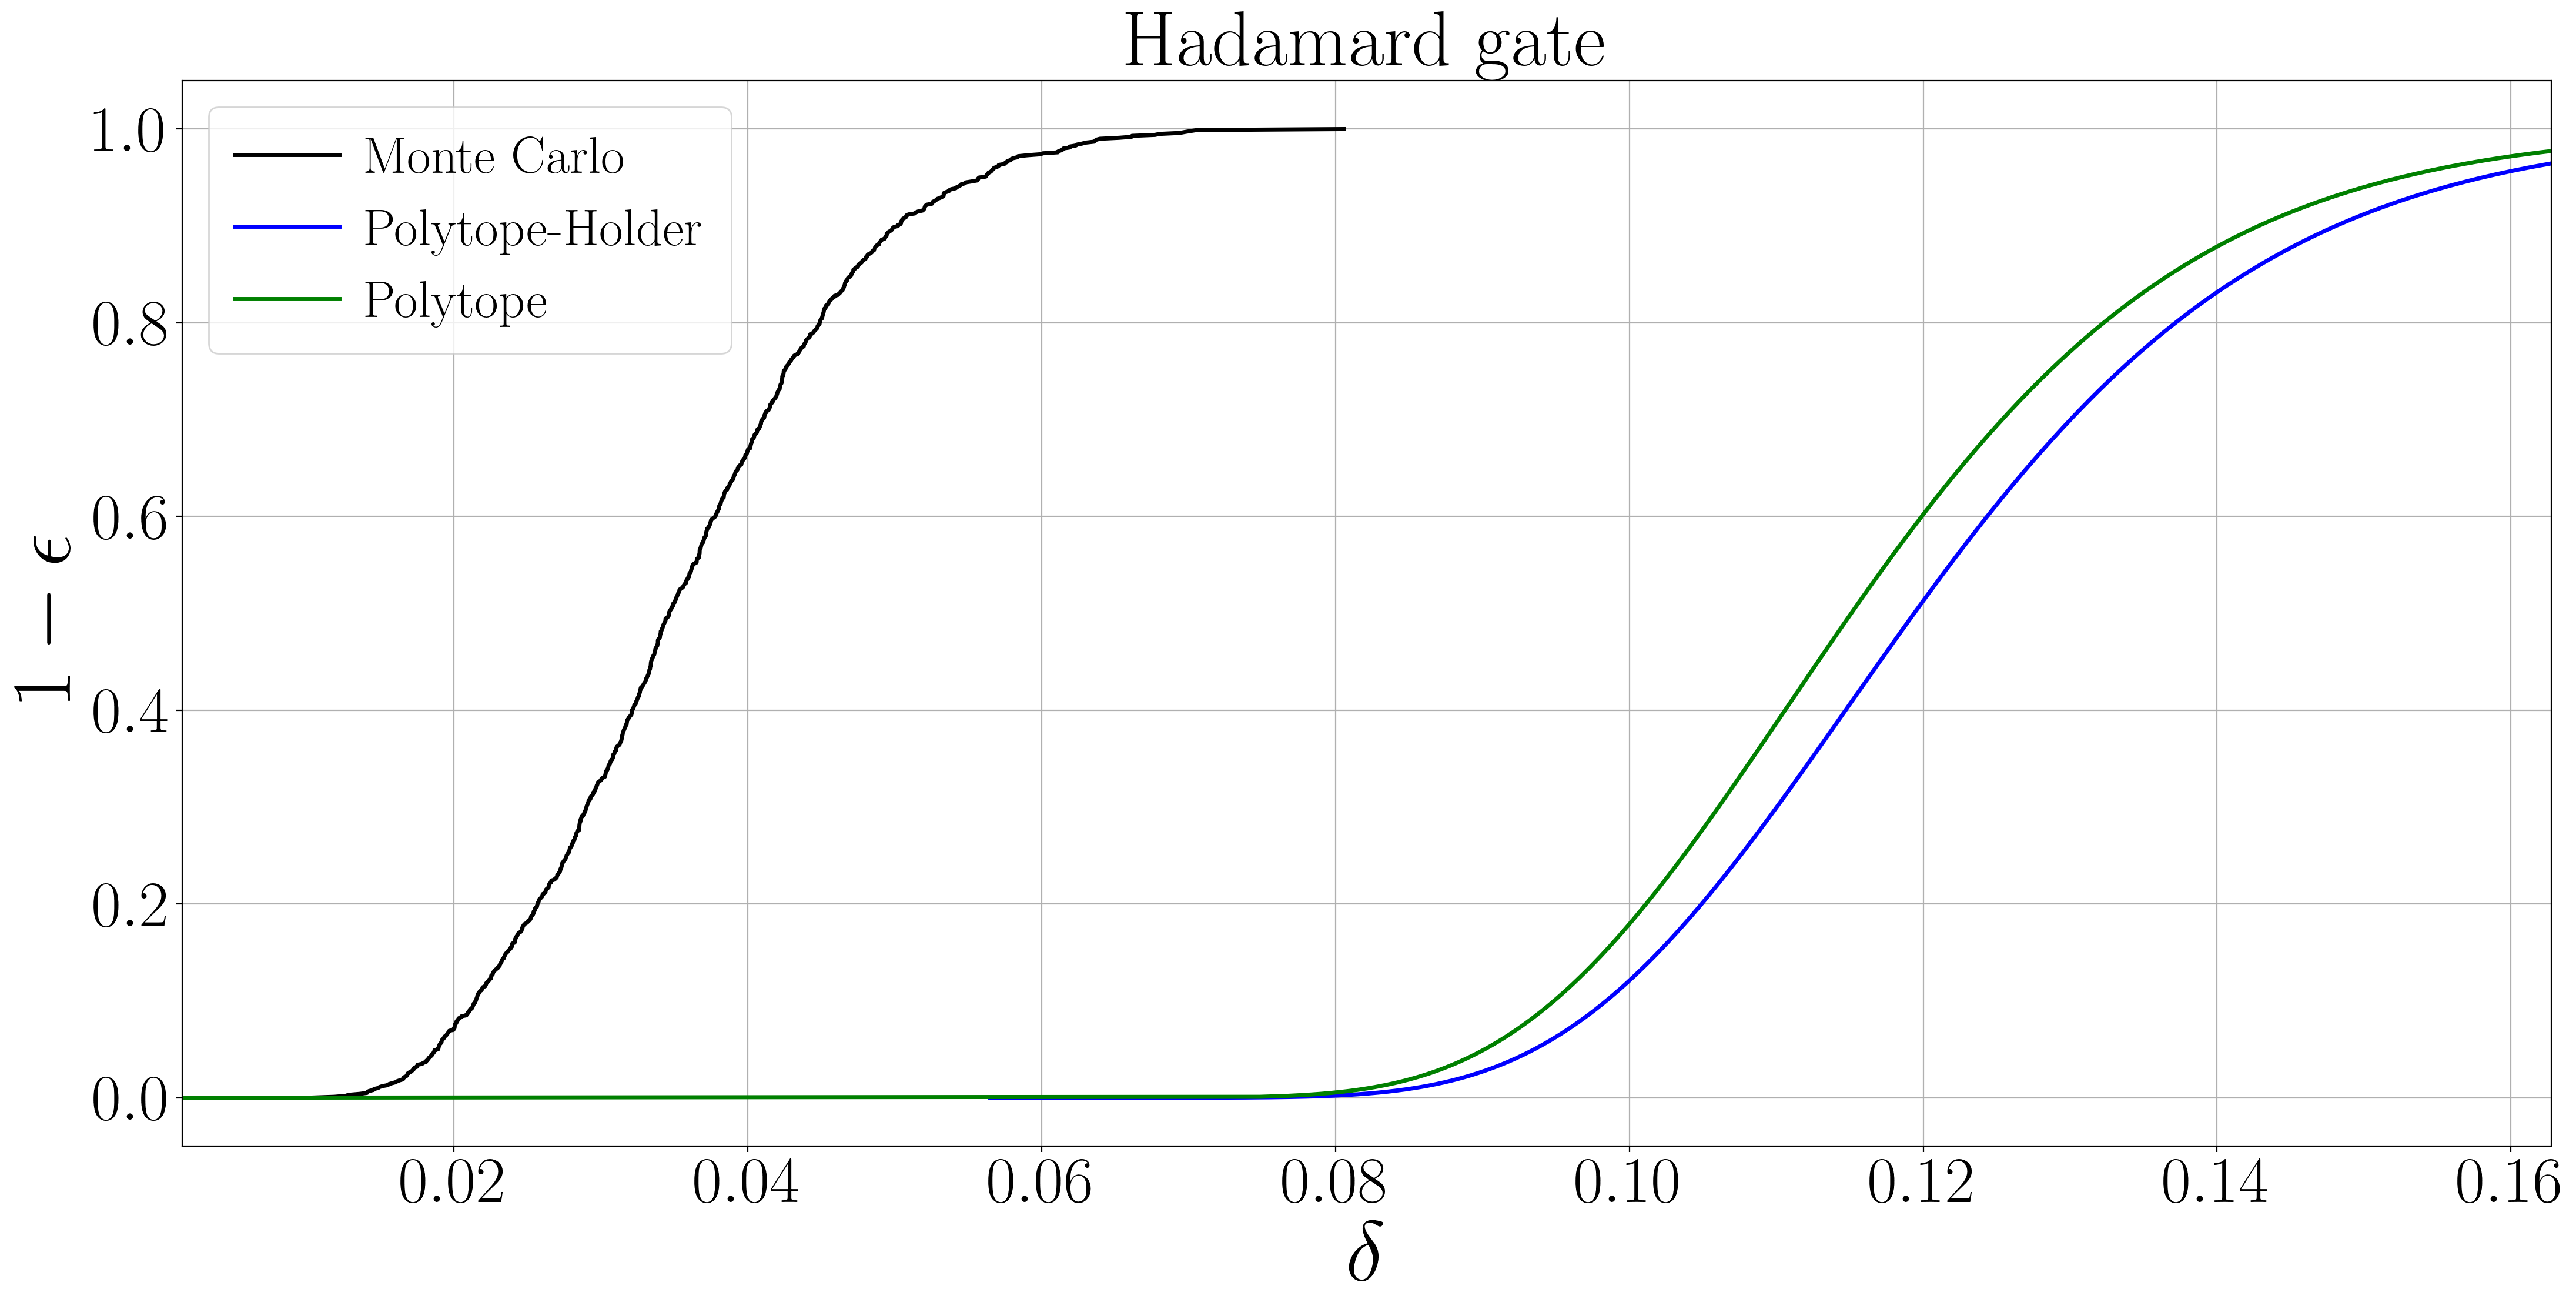

In [9]:
cc = cycler(color=list('kbgry'))
for i in [0]:
    process = processes.iloc[i]
    process_name = process['name']
    results = plot_intervals(show=True, img_path=f'../imgs/poster/{process_name}.png',
                             results_path=f'../imgs/poster/{process_name}.pkl',
                             title=process['title'], legend=True, cc=cc, figsize=(26, 12))

In [21]:
for _, process in tqdm(list(noised_processes.iterrows())[:12]):
    if not (process['name'].startswith("hadamard") or process['name'].startswith("cnot")):
        continue
    process_name = process['name']
    tmg = qp.ProcessTomograph(process['process'])
    tmg.experiment(process['n_meas'], povm=process['povm'])
    process_hat = tmg.point_estimate('lifp')
    intervals = {
        'Polytope (bbox)': HolderCorrectInterval(tmg, kind='wang', wang_method='bbox'),
        'Japan': HolderCorrectInterval(tmg, kind='sugiyama'),
        'Polytope (coarse)': HolderCorrectInterval(tmg, kind='wang', wang_method='coarse'),
        'True': qp.BootstrapProcessInterval(tmg, channel=process['process'])
    }
    if process['process'].n_qubits == 1:
        intervals['Polytope (exact)'] = HolderCorrectInterval(tmg, kind='wang', wang_method='exact')
    construct_intervals(intervals, f'../results/process/{process_name}.pkl')

In [25]:
cc = (cycler(color=list('kgkrk')) + cycler(linestyle=['-', '-', ':', '-', (0, (5, 12))]))
for _, process in tqdm(list(noised_processes.iterrows())):
    if not (process['name'].startswith("hadamard") or process['name'].startswith("cnot")):
        continue
    process_name = process['name']
    results = plot_intervals(results_path=f'../results/process/{process_name}.pkl', show=False, 
                             img_path=f'../imgs/polytopes_paper/process/{process_name}.png', 
                             title=process['title'], legend=False, cc=cc, figsize=(18, 12))

FileNotFoundError: [Errno 2] No such file or directory: '../results/process/hadamard_0.25.pkl'

In [13]:
# bbox, japan, opnorm, vertex, 
cc = (cycler(color=list('kbgry')) * cycler(linestyle=['-', '-.', ':', (0, (5, 12))]))
for _, process in tqdm(processes.iterrows()):
    if process['process'].n_qubits == 1:
        continue
    process_name = process['name']
    tmg = qp.ProcessTomograph(process['process'])
    tmg.experiment(process['n_meas'], povm=process['povm'])
    intervals = {
#         'Polytope (bbox)': qp.HolderInterval(tmg, kind='wang', wang_method='bbox'),
        'Japan': qp.HolderInterval(tmg, kind='sugiyama'),
    }
    results, times = plot_intervals(intervals, show=False, 
                                    path=f'../imgs/polytopes_paper/process/{process_name}_no_opnorm.png', 
                                    title=None, legend=False, cc=cc, figsize=(12, 12))